## General information

This kernel is dedicated to EDA of PetFinder.my Adoption Prediction challenge as well as feature engineering and modelling.

![](https://i.imgur.com/rvSWCYO.png)
(a screenshot of the PetFinder.my site)

In this dataset we have lots of information: tabular data, texts and even images! This gives a lot of possibilties for feature engineering and modelling. The only limiting factor is the fact that the competition is kernel-only. On the other hand this will ensure everyone has the same computational resources.

In this kernel I want to pay attention to several things:
* comparing distribution of features in train and test data;
* exploring features and their interactions;
* trying various types of feature engineering;
* trying various models without neural nets (for now);

It is important to remember that this competition has stage 2, so our models will run against unseen data.

*Work still in progress*

In [1]:
#libraries
import numpy as np 
import pandas as pd 
import os

import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import plotly.offline as py
py.init_notebook_mode(connected=True)

import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings("ignore")


In [2]:
breeds = pd.read_csv('./data/petfinder-adoption-prediction/breed_labels.csv')
colors = pd.read_csv('./data/petfinder-adoption-prediction/color_labels.csv')
states = pd.read_csv('./data/petfinder-adoption-prediction/state_labels.csv')

train = pd.read_csv('./data/petfinder-adoption-prediction/train/train.csv')
test = pd.read_csv('./data/petfinder-adoption-prediction/test/test.csv')
sub = pd.read_csv('./data/petfinder-adoption-prediction/test/sample_submission.csv')

train['dataset_type'] = 'train'
test['dataset_type'] = 'test'
all_data = pd.concat([train, test])

## Data overview

Let's have a quick look at the data first!

In [3]:
print(os.listdir("./data/petfinder-adoption-prediction"))

['state_labels.csv', 'breed_labels.csv', 'test_sentiment', 'PetFinder-StateLabels.csv', 'BreedLabels.csv', 'ColorLabels.csv', 'train_metadata', 'test', 'test_metadata', 'PetFinder-ColorLabels.csv', 'color_labels.csv', 'train', 'test_images', 'PetFinder-BreedLabels.csv', 'StateLabels.csv', 'train_sentiment', 'train_images']


In [4]:
train.drop('Description', axis=1).head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,PetID,PhotoAmt,AdoptionSpeed,dataset_type
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,86e1089a3,1.0,2,train
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,6296e909a,2.0,0,train
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,3422e4906,7.0,3,train
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,5842f1ff5,8.0,2,train
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,850a43f90,3.0,2,train


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13736 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14993 non-null  int64  
 18  Rescue

* We have almost 15 thousands dogs and cats in the dataset;
* Main dataset contains all important information about pets: age, breed, color, some characteristics and other things;
* Desctiptions were analyzed using Google's Natural Language API providing sentiments and entities. I suppose we could do a similar thing ourselves;
* There are photos of some pets;
* Some meta-information was extracted from images and we can use it;
* There are separate files with labels for breeds, colors and states;

Let's start with the main dataset.

I have also created a full dataset by combining train and test data. This is done purely for more convenient visualization. Column "dataset_type" shows which dataset the data belongs to.

## Main data exploration

### Target: Adoption speed

* 0 - Pet was adopted on the same day as it was listed.
* 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
* 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
* 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
* 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days). 

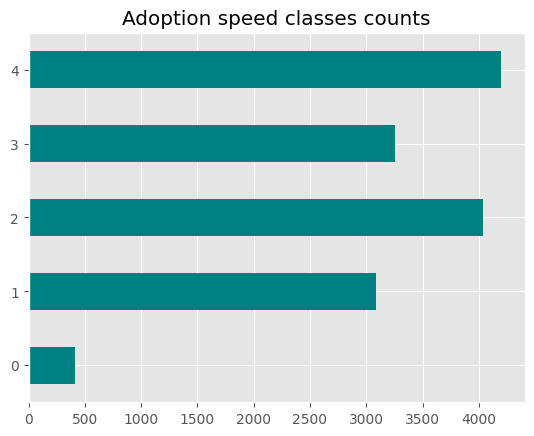

In [81]:
train['AdoptionSpeed'].value_counts().sort_index().plot(kind = 'barh', color='teal');
plt.title('Adoption speed classes counts');

A small note on how annotating works:
* When I use seaborn countplot, I assign the figure to a variable - this allows to change its attributes and go deeper into its parameters;
* Figure has `Axes` - bars - which contain information about color, transparency and other parameters;
* And `patches` in `Axes` contain this information;
* So we can take information from 'patches`, for example width and height of each bar, and plot correct text in correct places

https://matplotlib.org/users/artists.html

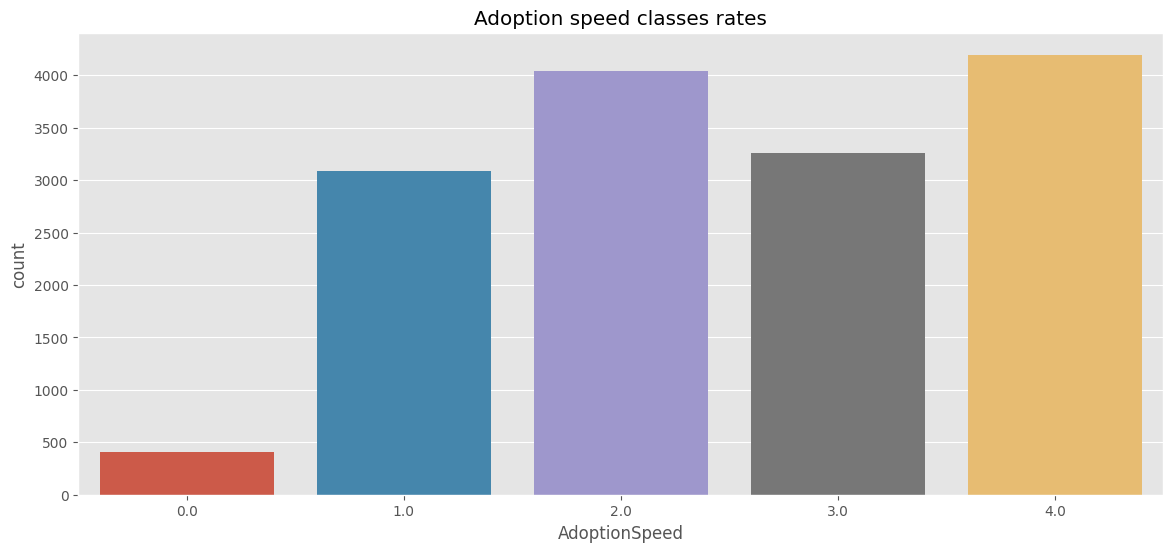

In [82]:
plt.figure(figsize=(14, 6));
g = sns.countplot(x='AdoptionSpeed', data=all_data.loc[all_data['dataset_type'] == 'train']);
plt.title('Adoption speed classes rates');
ax=g.axes

In [83]:
#Axes
ax

<Axes: title={'center': 'Adoption speed classes rates'}, xlabel='AdoptionSpeed', ylabel='count'>

In [84]:
# patches
ax.patches

<Axes.ArtistList of 5 patches>

In [85]:
# example of info in patches
ax.patches[0].get_x()

-0.4

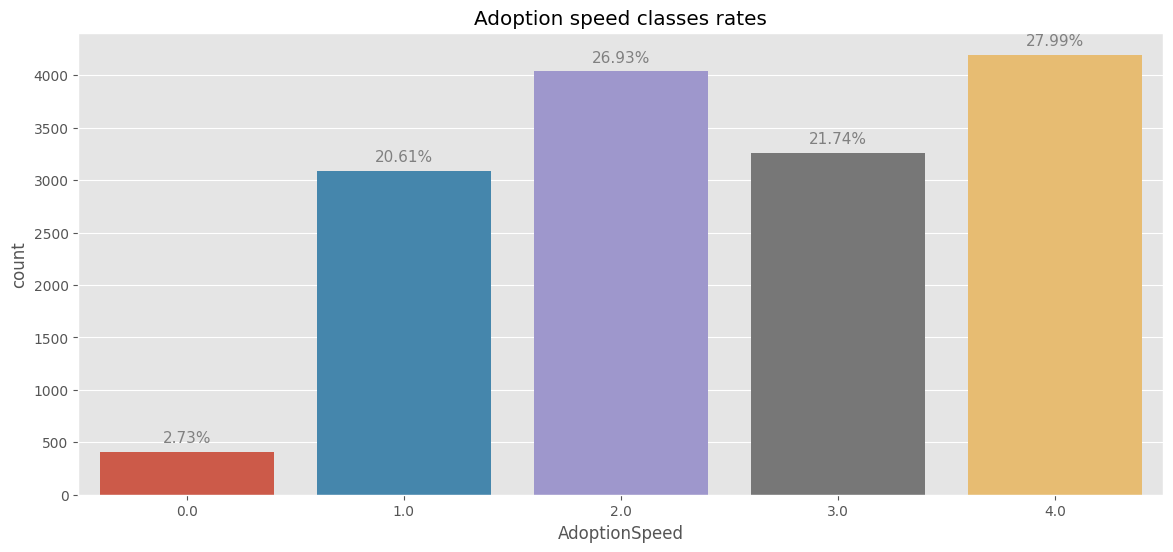

In [6]:
plt.figure(figsize=(14, 6));
g = sns.countplot(x='AdoptionSpeed', data=all_data.loc[all_data['dataset_type'] == 'train'])
plt.title('Adoption speed classes rates');
ax=g.axes
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / train.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 10),
         textcoords='offset points')  

We can see that some pets were adopted immediately, but these are rare cases: maybe someone wanted to adopt any pet, or the pet was lucky to be seen by person, who wanted a similar pet.
A lot of pets aren't adopted at all, which is quite sad :( I hope our models and analysis will help them to find their home!

It is nice that a lot of pets are adopted within a first week of being listed!

One more interesting thing is that the classes have a linear relationship - the higher the number, the worse situation is. So it could be possible to build not only multiclass classification, but also regression.

### Type
1 - Dog, 2 - Cat

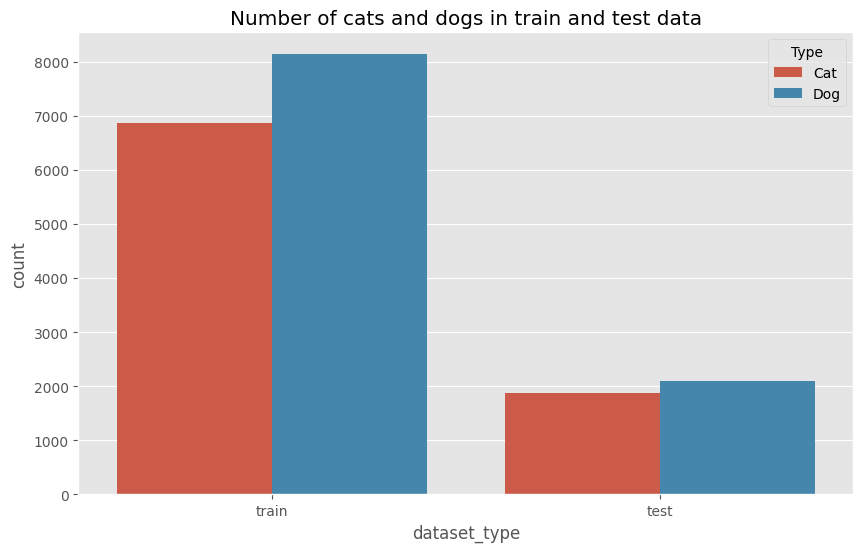

In [7]:
all_data['Type'] = all_data['Type'].apply(lambda x: 'Dog' if x == 1 else 'Cat')
plt.figure(figsize=(10, 6));
sns.countplot(x='dataset_type', data=all_data, hue='Type');
plt.title('Number of cats and dogs in train and test data');

We can see that the rate of dogs in train dataset is higher that in test set. But I don't think the difference is seriuos.

#### Comparison of rates

From here on I'll compare not only counts of pets in different categories, but also compate adoption speed rates with base ones.

This is how it works:
* As we saw earlier the base rate of pets with Adoption speed 0 is 410 / 14993 = 0.027;
* Now look at the next graph: there are 6861 cats in train dataset and 240 of them have Adoption Speed 0. So the rate is 240 / 6861 = 0.035;
* 0.035/0.027 = 1.28, so by splitting out the data to cat vs dog, we can see that cats have a 28% increased chance of adoption speed class 0 over the base rate of adoption;

In [8]:
main_count = train['AdoptionSpeed'].value_counts(normalize=True).sort_index()
def prepare_plot_dict(df, col, main_count):
    """
    Preparing dictionary with data for plotting.
    
    I want to show how much higher/lower are the rates of Adoption speed for the current column comparing to base values (as described higher),
    At first I calculate base rates, then for each category in the column I calculate rates of Adoption speed and find difference with the base rates.
    
    """
    main_count = dict(main_count)
    plot_dict = {}
    for i in df[col].unique():
        val_count = dict(df.loc[df[col] == i, 'AdoptionSpeed'].value_counts().sort_index())

        for k, v in main_count.items():
            if k in val_count:
                plot_dict[val_count[k]] = ((val_count[k] / sum(val_count.values())) / main_count[k]) * 100 - 100
            else:
                plot_dict[0] = 0

    return plot_dict

def make_count_plot(df, x, hue='AdoptionSpeed', title='', main_count=main_count):
    """
    Plotting countplot with correct annotations.
    """
    g = sns.countplot(x=x, data=df, hue=hue);
    plt.title(f'AdoptionSpeed {title}');
    ax = g.axes

    plot_dict = prepare_plot_dict(df, x, main_count)

    for p in ax.patches:
        h = p.get_height() if str(p.get_height()) != 'nan' else 0
        text = f"{plot_dict[h]:.0f}%" if plot_dict[h] < 0 else f"+{plot_dict[h]:.0f}%"
        ax.annotate(text, (p.get_x() + p.get_width() / 2., h),
             ha='center', va='center', fontsize=11, color='green' if plot_dict[h] > 0 else 'red', rotation=0, xytext=(0, 10),
             textcoords='offset points')  

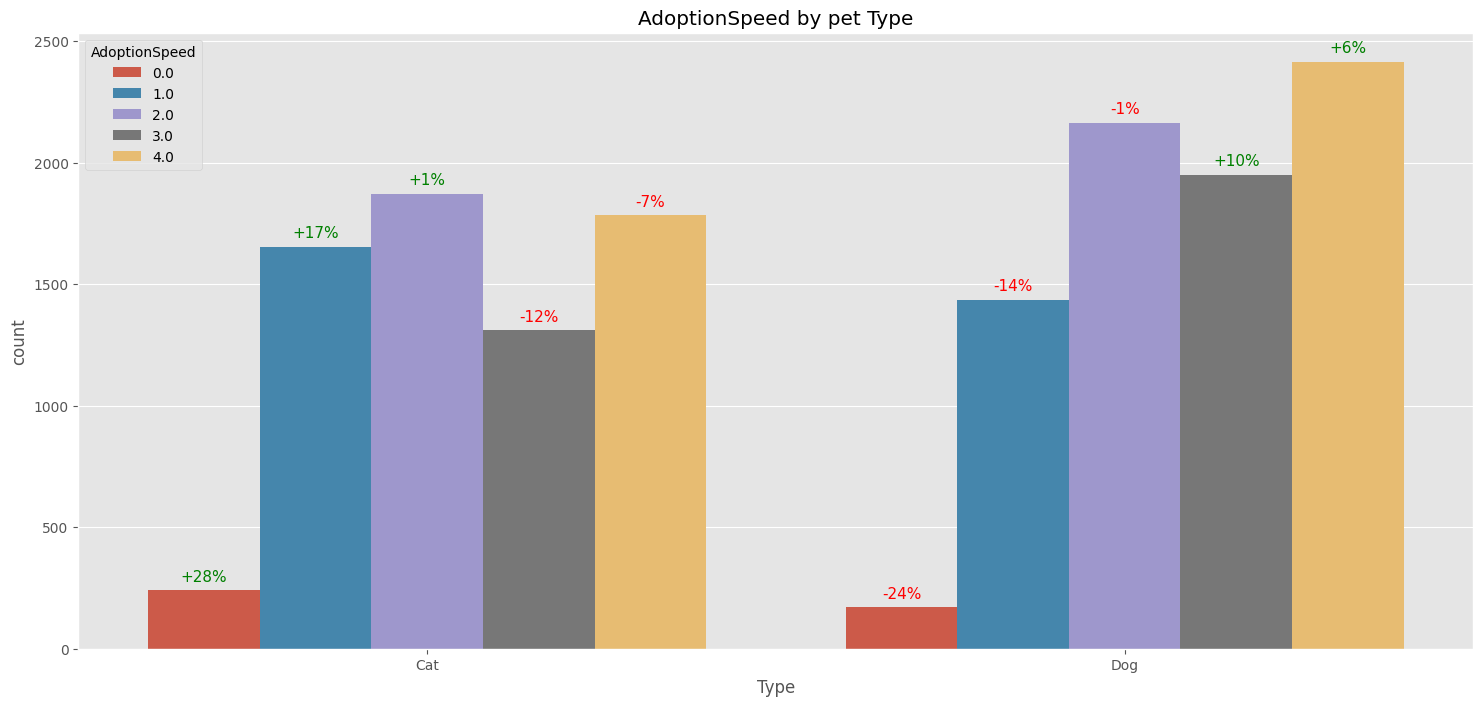

In [9]:
plt.figure(figsize=(18, 8));
make_count_plot(df=all_data.loc[all_data['dataset_type'] == 'train'], x='Type', title='by pet Type')

We can see that cats are more likely to be adopted early than dogs and overall the percentage of not adopted cats is lower. Does this mean people prefer cats? Or maybe this dataset is small and could contain bias.
On the other hand more dogs are adopted after several months.

### Age

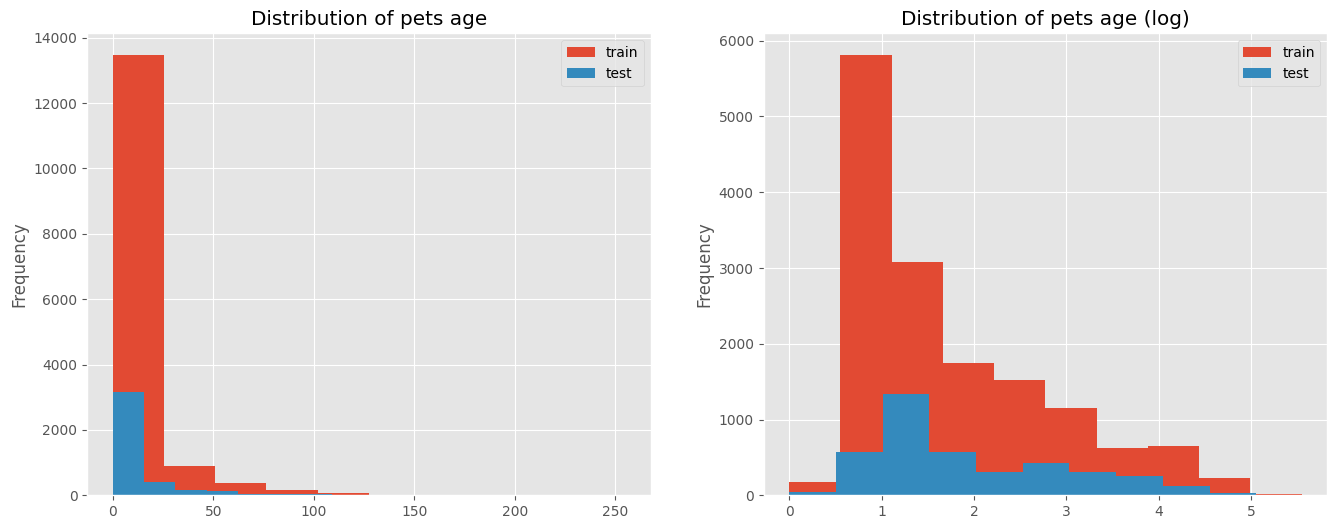

In [25]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.title('Distribution of pets age');
train['Age'].plot(kind = 'hist', label='train');

test['Age'].plot(kind = 'hist', label='test');
plt.legend();

plt.subplot(1, 2, 2)
plt.title('Distribution of pets age (log)');
np.log1p(train['Age']).plot(kind = 'hist', label='train');
np.log1p(test['Age']).plot(kind = 'hist', label='test');
plt.legend();

In [26]:
train['Age'].value_counts().head(10)

2     3503
1     2304
3     1966
4     1109
12     967
24     651
5      595
6      558
36     417
8      309
Name: Age, dtype: int64

We can see that most pets are young - maybe after the birth. Also there a lot of pets with an age equal to multiples of 12 - I think than owners didn't bother with the exact age.

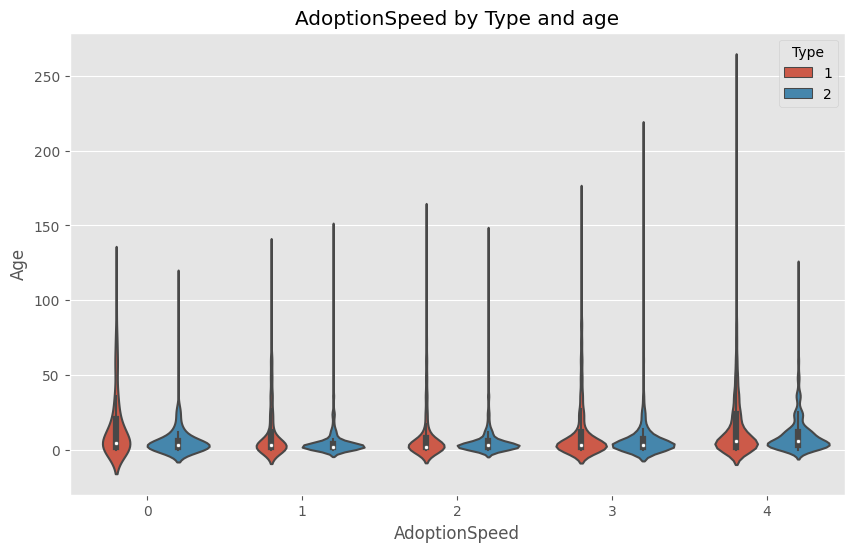

In [29]:
plt.figure(figsize=(10, 6));
sns.violinplot(x="AdoptionSpeed", y="Age", hue="Type", data=train);
plt.title('AdoptionSpeed by Type and age');

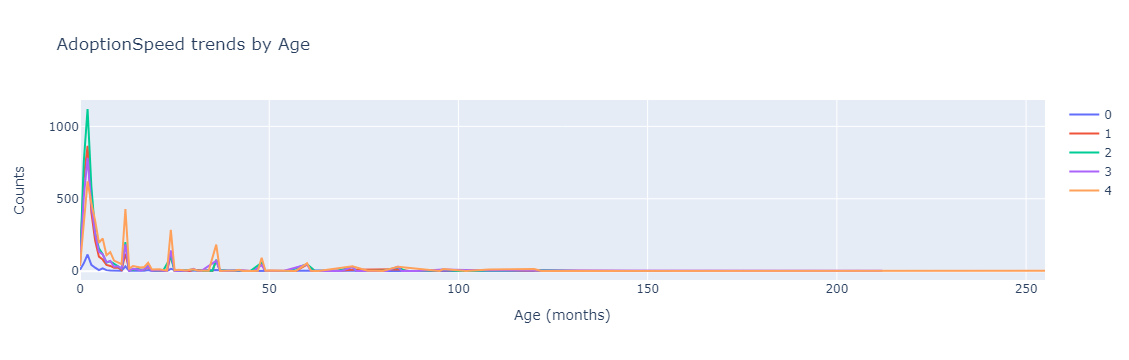

In [30]:
data = []
for a in range(5):
    df = train.loc[train['AdoptionSpeed'] == a]

    data.append(go.Scatter(
        x = df['Age'].value_counts().sort_index().index,
        y = df['Age'].value_counts().sort_index().values,
        name = str(a)
    ))
    
layout = go.Layout(dict(title = "AdoptionSpeed trends by Age",
                  xaxis = dict(title = 'Age (months)'),
                  yaxis = dict(title = 'Counts'),
                  )
                  )
py.iplot(dict(data=data, layout=layout), filename='basic-line')

* We can see that young pets are adopted quite fast and most of them are adopted;
* Most pets are less than 4 months old with a huge spike at 2 months;
* It seems that a lot of people don't input exact age and write age in years (or multiples of 12);
* It could make sense to create some binary variables based on age;

### Breeds
There is a main breed of the pet and secondary if relevant.

At first let's see whether having secondary breed influences adoption speed.

In [31]:
train['Pure_breed'] = 0
train.loc[train['Breed2'] == 0, 'Pure_breed'] = 1
test['Pure_breed'] = 0
test.loc[test['Breed2'] == 0, 'Pure_breed'] = 1
all_data['Pure_breed'] = 0
all_data.loc[all_data['Breed2'] == 0, 'Pure_breed'] = 1

print(f"Rate of pure breed pets in train data: {train['Pure_breed'].sum() * 100 / train['Pure_breed'].shape[0]:.4f}%.")
print(f"Rate of pure breed pets in test data: {test['Pure_breed'].sum() * 100 / test['Pure_breed'].shape[0]:.4f}%.")

Rate of pure breed pets in train data: 71.7802%.
Rate of pure breed pets in test data: 74.6979%.


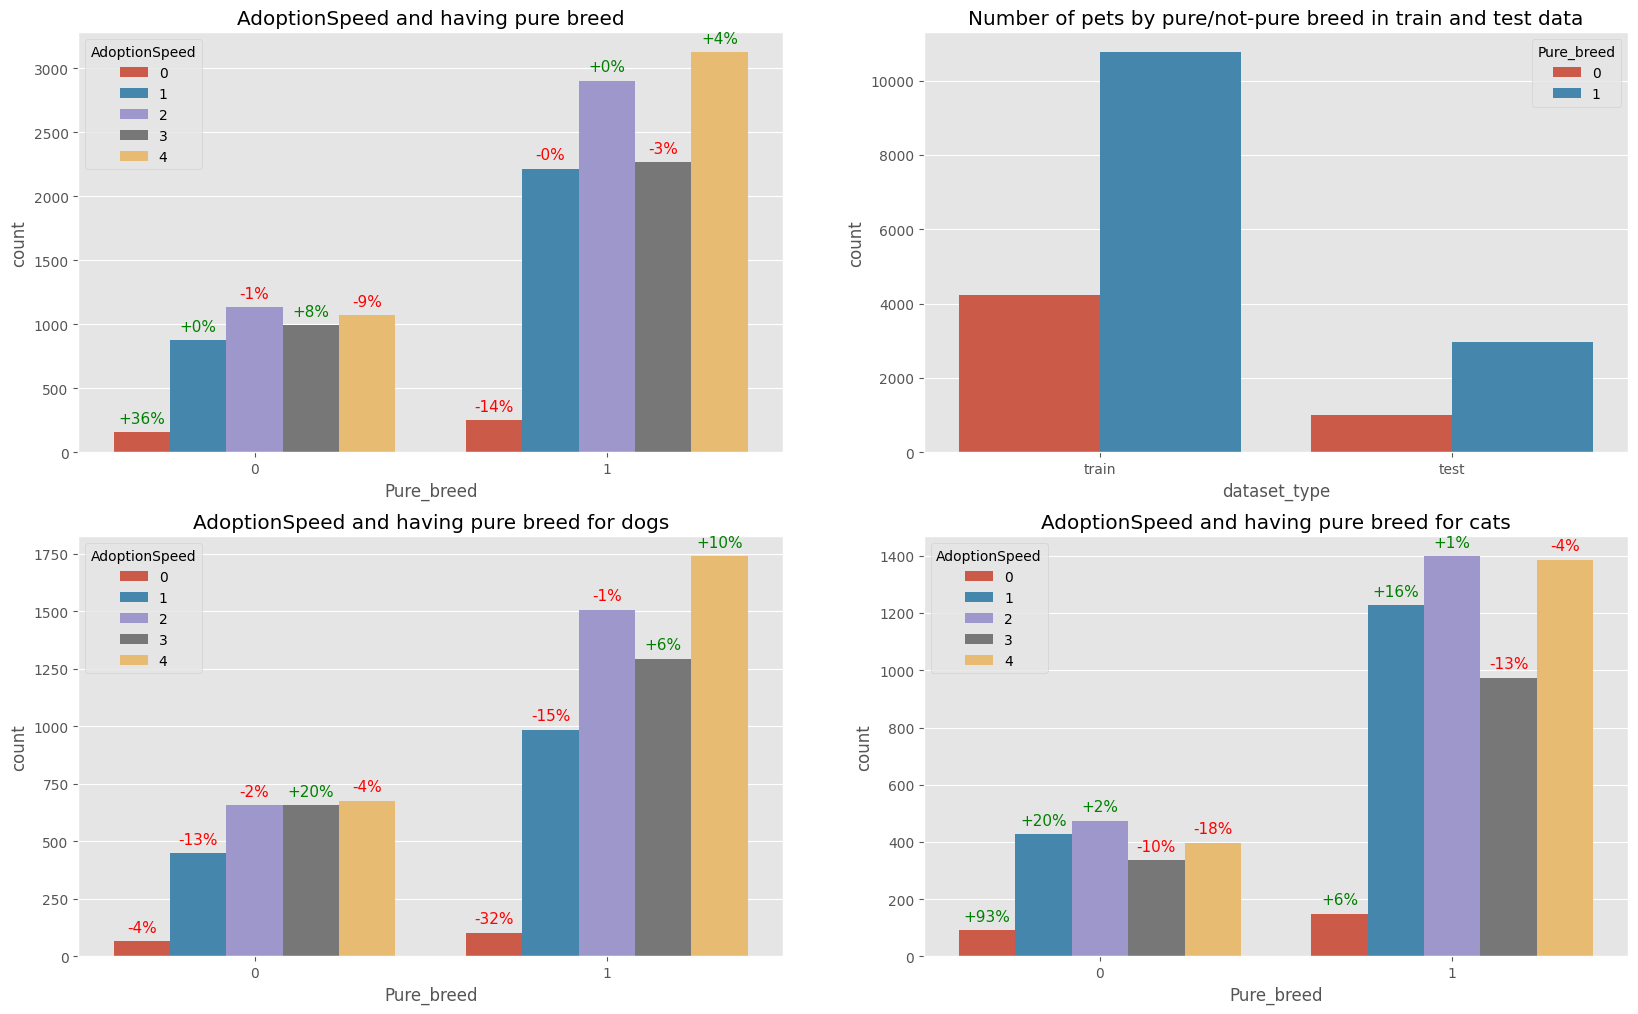

In [32]:
def plot_four_graphs(col='', main_title='', dataset_title=''):
    """
    Plotting four graphs:
    - adoption speed by variable;
    - counts of categories in the variable in train and test;
    - adoption speed by variable for dogs;
    - adoption speed by variable for cats;    
    """
    plt.figure(figsize=(20, 12));
    plt.subplot(2, 2, 1)
    make_count_plot(df=train, x=col, title=f'and {main_title}')

    plt.subplot(2, 2, 2)
    sns.countplot(x='dataset_type', data=all_data, hue=col);
    plt.title(dataset_title);

    plt.subplot(2, 2, 3)
    make_count_plot(df=train.loc[train['Type'] == 1], x=col, title=f'and {main_title} for dogs')

    plt.subplot(2, 2, 4)
    make_count_plot(df=train.loc[train['Type'] == 2], x=col, title=f'and {main_title} for cats')
    
plot_four_graphs(col='Pure_breed', main_title='having pure breed', dataset_title='Number of pets by pure/not-pure breed in train and test data')

It seems that non-pure breed pets tend to be adopted more and faster, especially cats.

Let's look at the breeds themselves

### Gender
 1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets

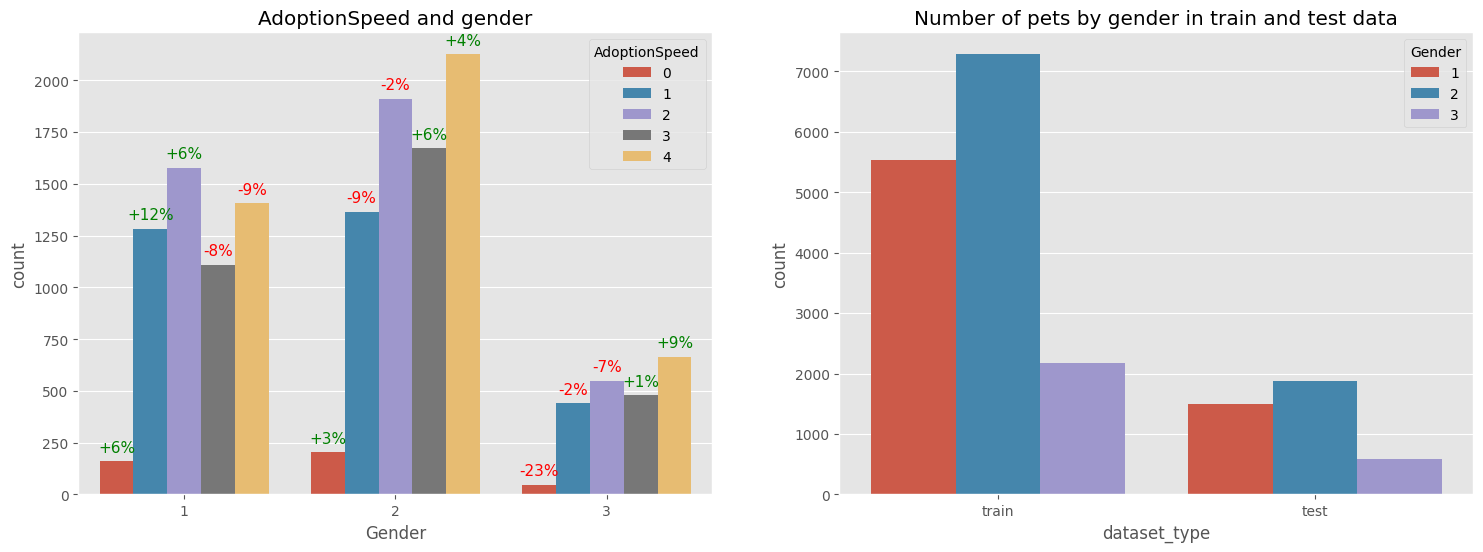

In [36]:
plt.figure(figsize=(18, 6));
plt.subplot(1, 2, 1)
make_count_plot(df=train, x='Gender', title='and gender')

plt.subplot(1, 2, 2)
sns.countplot(x='dataset_type', data=all_data, hue='Gender');
plt.title('Number of pets by gender in train and test data');

In [39]:
sns.factorplot('Type', col='Gender', data=all_data, kind='count', hue='dataset_type');
plt.subplots_adjust(top=0.8)
plt.suptitle('Count of cats and dogs in train and test set by gender');

AttributeError: module 'seaborn' has no attribute 'factorplot'

In [ ]:
# create your plot with catplot() instead of factorplot()
# sns.catplot(x='day', y='tip', data=tips)

It seems that male pets are adopted faster than female. Having no information about the gender really decreases chances.

### Colors

In [40]:
colors_dict = {k: v for k, v in zip(colors['ColorID'], colors['ColorName'])}
train['Color1_name'] = train['Color1'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
train['Color2_name'] = train['Color2'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
train['Color3_name'] = train['Color3'].apply(lambda x: colors_dict[x] if x in colors_dict else '')

test['Color1_name'] = test['Color1'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
test['Color2_name'] = test['Color2'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
test['Color3_name'] = test['Color3'].apply(lambda x: colors_dict[x] if x in colors_dict else '')

all_data['Color1_name'] = all_data['Color1'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
all_data['Color2_name'] = all_data['Color2'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
all_data['Color3_name'] = all_data['Color3'].apply(lambda x: colors_dict[x] if x in colors_dict else '')

In [41]:
def make_factor_plot(df, x, col, title, main_count=main_count, hue=None, ann=True, col_wrap=4):
    """
    Plotting countplot.
    Making annotations is a bit more complicated, because we need to iterate over axes.
    """
    if hue:
        g = sns.factorplot(col, col=x, data=df, kind='count', col_wrap=col_wrap, hue=hue);
    else:
        g = sns.factorplot(col, col=x, data=df, kind='count', col_wrap=col_wrap);
    plt.subplots_adjust(top=0.9);
    plt.suptitle(title);
    ax = g.axes
    plot_dict = prepare_plot_dict(df, x, main_count)
    if ann:
        for a in ax:
            for p in a.patches:
                text = f"{plot_dict[p.get_height()]:.0f}%" if plot_dict[p.get_height()] < 0 else f"+{plot_dict[p.get_height()]:.0f}%"
                a.annotate(text, (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=11, color='green' if plot_dict[p.get_height()] > 0 else 'red', rotation=0, xytext=(0, 10),
                     textcoords='offset points')  

In [42]:
sns.factorplot('dataset_type', col='Type', data=all_data, kind='count', hue='Color1_name', palette=['Black', 'Brown', '#FFFDD0', 'Gray', 'Gold', 'White', 'Yellow']);
plt.subplots_adjust(top=0.8)
plt.suptitle('Counts of pets in datasets by main color');

AttributeError: module 'seaborn' has no attribute 'factorplot'

We can see that most common colors are black and brown. Interesting to notice that there are almost no gray or yellow dogs :)

Now let's see whether colors influence adoption speed

In [43]:
make_factor_plot(df=train, x='Color1_name', col='AdoptionSpeed', title='Counts of pets by main color and Adoption Speed')

AttributeError: module 'seaborn' has no attribute 'factorplot'

In [44]:
train['full_color'] = (train['Color1_name'] + '__' + train['Color2_name'] + '__' + train['Color3_name']).str.replace('__', '')
test['full_color'] = (test['Color1_name'] + '__' + test['Color2_name'] + '__' + test['Color3_name']).str.replace('__', '')
all_data['full_color'] = (all_data['Color1_name'] + '__' + all_data['Color2_name'] + '__' + all_data['Color3_name']).str.replace('__', '')

make_factor_plot(df=train.loc[train['full_color'].isin(list(train['full_color'].value_counts().index)[:12])], x='full_color', col='AdoptionSpeed', title='Counts of pets by color and Adoption Speed')

AttributeError: module 'seaborn' has no attribute 'factorplot'

We can see that there are some differences based on color, but the number of pets in most colors isn't very high, so this could be due to randomness.

In [45]:
gender_dict = {1: 'Male', 2: 'Female', 3: 'Mixed'}
for i in all_data['Type'].unique():
    for j in all_data['Gender'].unique():
        df = all_data.loc[(all_data['Type'] == i) & (all_data['Gender'] == j)]
        top_colors = list(df['full_color'].value_counts().index)[:5]
        j = gender_dict[j]
        print(f"Most popular colors of {j} {i}s: {' '.join(top_colors)}")

Most popular colors of Male Cats: BlackWhite Black GrayWhite White YellowWhite
Most popular colors of Female Cats: BlackWhite BlackBrownWhite BlackYellowWhite GrayWhite White
Most popular colors of Mixed Cats: BlackBrownWhite BlackGrayWhite BlackYellowWhite BlackWhite BlackGoldenWhite
Most popular colors of Male Dogs: Brown BlackBrown BrownWhite Black BlackWhite
Most popular colors of Female Dogs: Brown BlackBrown BrownWhite Black BlackWhite
Most popular colors of Mixed Dogs: BlackBrownWhite BlackBrown BlackBrownCream Brown BlackWhite


### MatiritySize
Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)

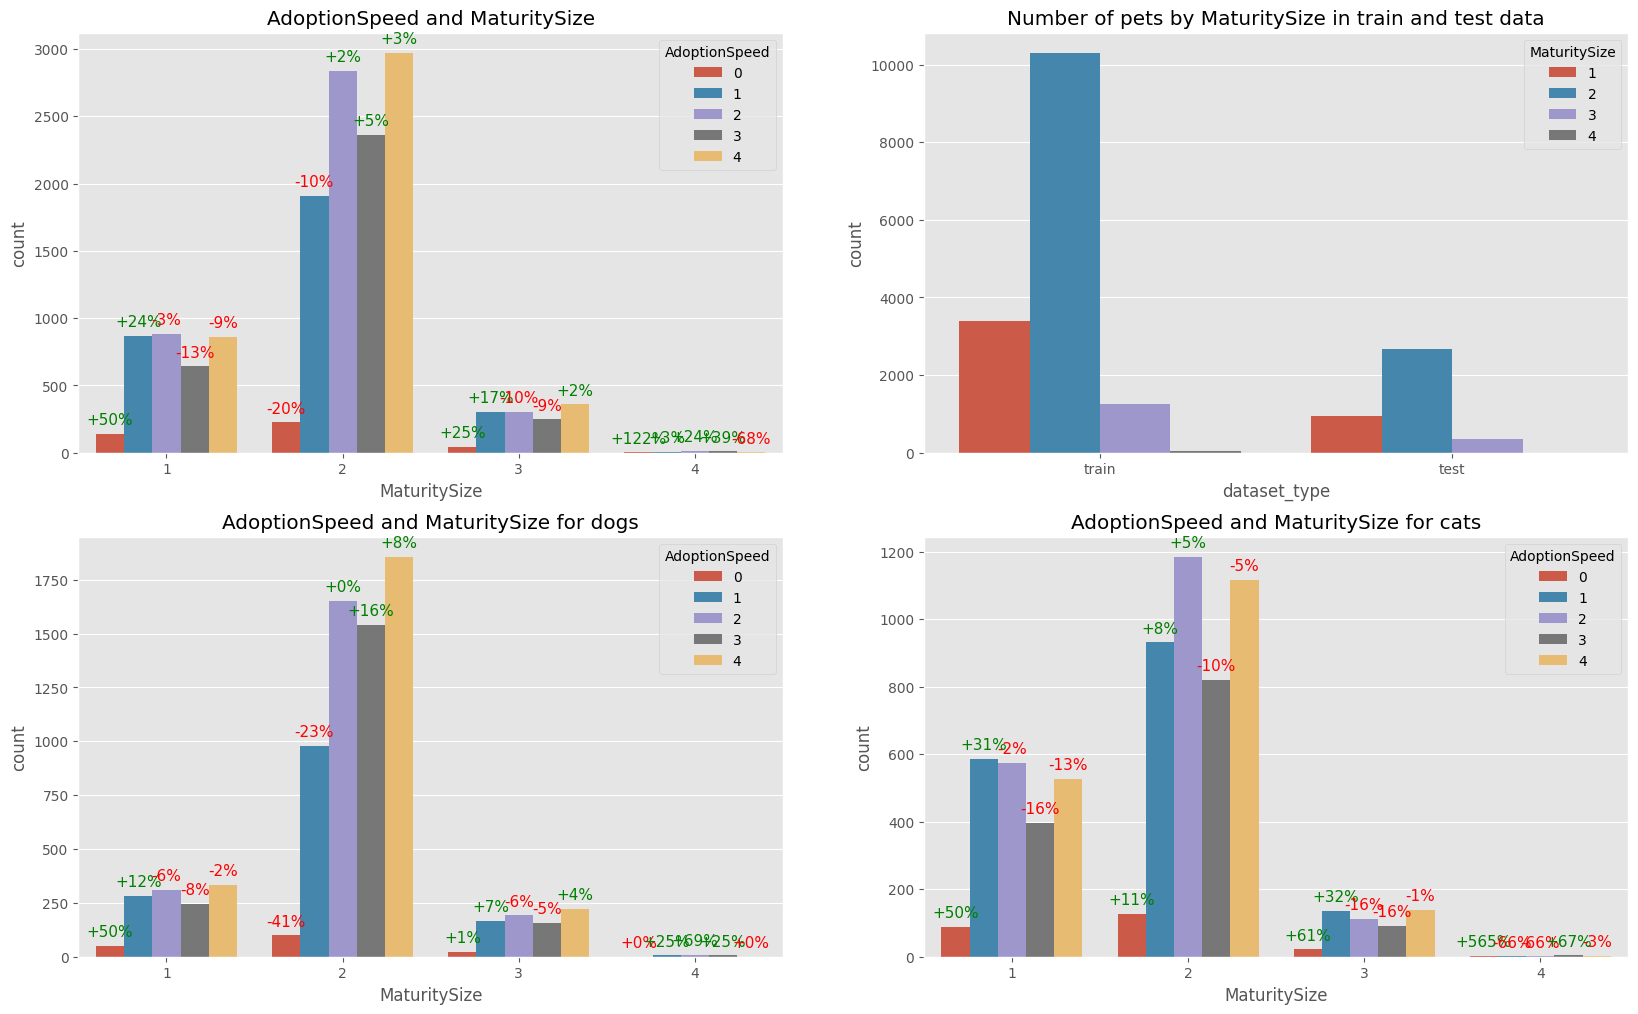

In [46]:
plot_four_graphs(col='MaturitySize', main_title='MaturitySize', dataset_title='Number of pets by MaturitySize in train and test data')

In [47]:
make_factor_plot(df=all_data, x='MaturitySize', col='Type', title='Count of cats and dogs in train and test set by MaturitySize', hue='dataset_type', ann=False)

AttributeError: module 'seaborn' has no attribute 'factorplot'

In [ ]:
images = [i.split('-')[0] for i in os.listdir('../input/train_images/')]
size_dict = {1: 'Small', 2: 'Medium', 3: 'Large', 4: 'Extra Large'}
for t in all_data['Type'].unique():
    for m in all_data['MaturitySize'].unique():
        df = all_data.loc[(all_data['Type'] == t) & (all_data['MaturitySize'] == m)]
        top_breeds = list(df['Breed1_name'].value_counts().index)[:5]
        m = size_dict[m]
        print(f"Most common Breeds of {m} {t}s:")
        
        fig = plt.figure(figsize=(25, 4))
        
        for i, breed in enumerate(top_breeds):
            # excluding pets without pictures
            b_df = df.loc[(df['Breed1_name'] == breed) & (df['PetID'].isin(images)), 'PetID']
            if len(b_df) > 1:
                pet_id = b_df.values[1]
            else:
                pet_id = b_df.values[0]
            ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])

            im = Image.open("../input/train_images/" + pet_id + '-1.jpg')
            plt.imshow(im)
            ax.set_title(f'Breed: {breed}')
        plt.show();

Quite interesting:
* We can see that maturity size isn't very important. Medium sized pets are most common and they have slightly more chances to be not adopted;
* There are almost no Extra Large pets. I hope it means that their owners like them and there is no need for them to be adopted :)
* I wanted to gave a look at different pets, so I showed examples of pictures of most common breeds for each maturity size of cats and dogs;
* I think not all data is entirely correct: sometimes short haired cats have breed with "medium hair", not sure that all breeds are entirely correct. Some photoes have bad quality;

### FurLength

 (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)

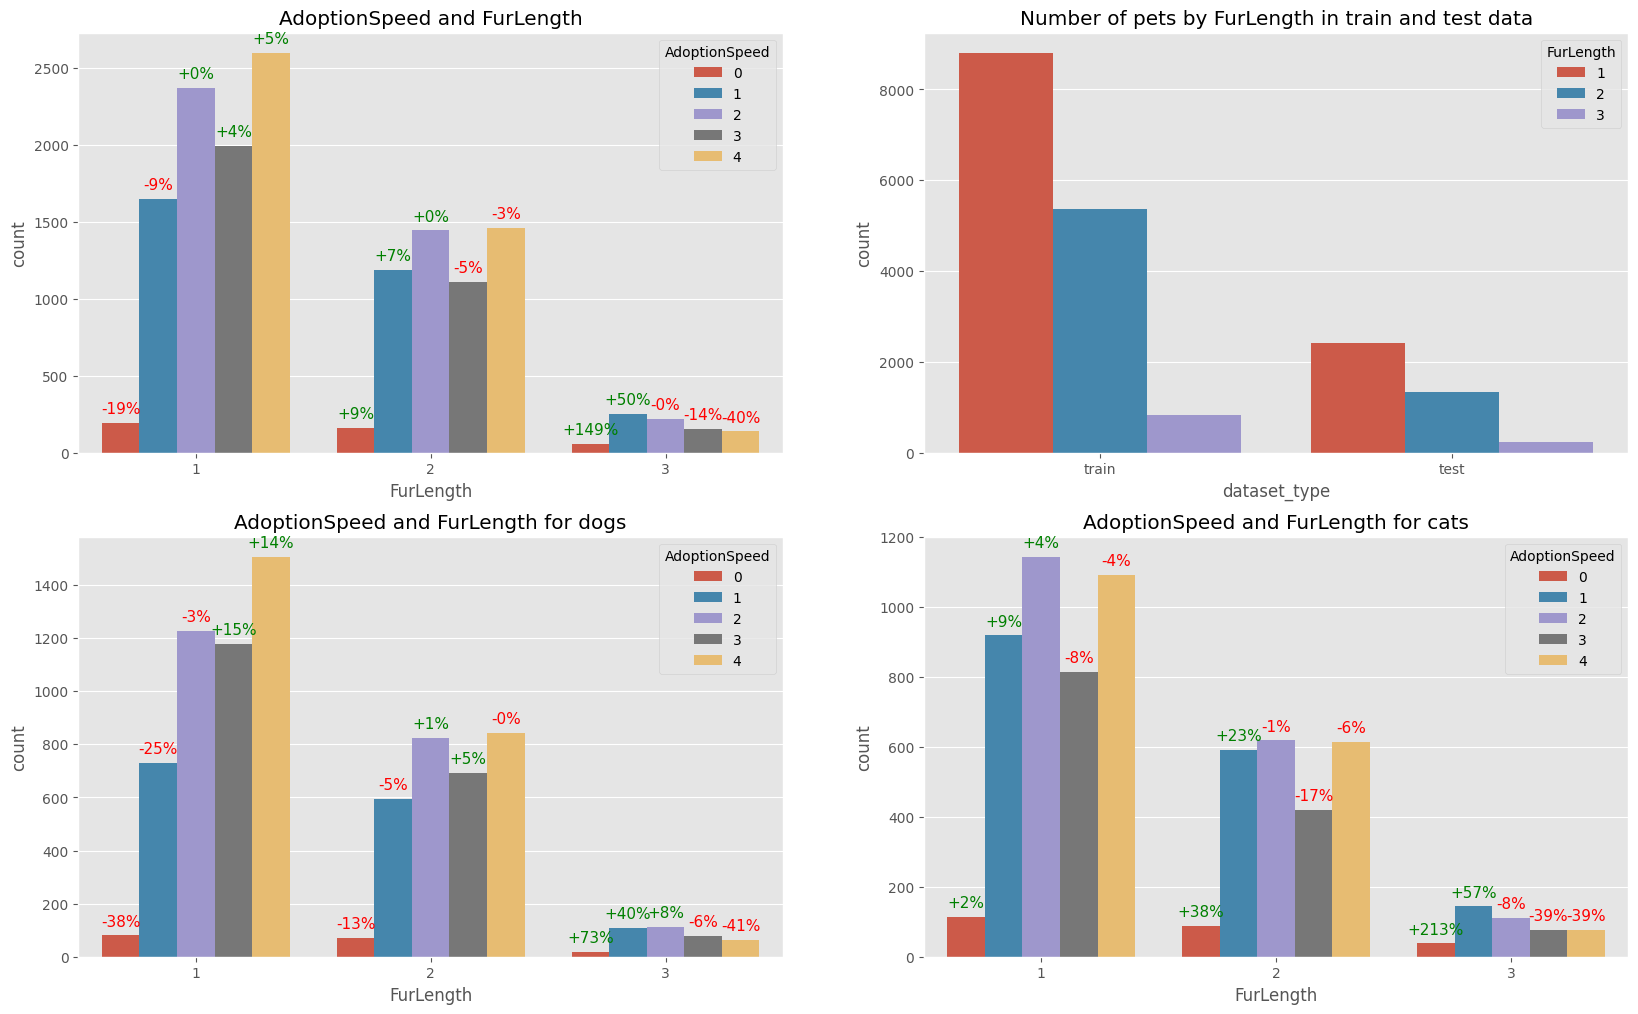

In [48]:
plot_four_graphs(col='FurLength', main_title='FurLength', dataset_title='Number of pets by FurLength in train and test data')

* We can see that most of the pets have short fur and long fur is the least common;
* Pets with long hair tend to have a higher chance of being adopted. Though it could be because of randomness due to low count;

As I said earlier, some breed have hair length in the text, let's check these values!

NameError: name 'WordCloud' is not defined

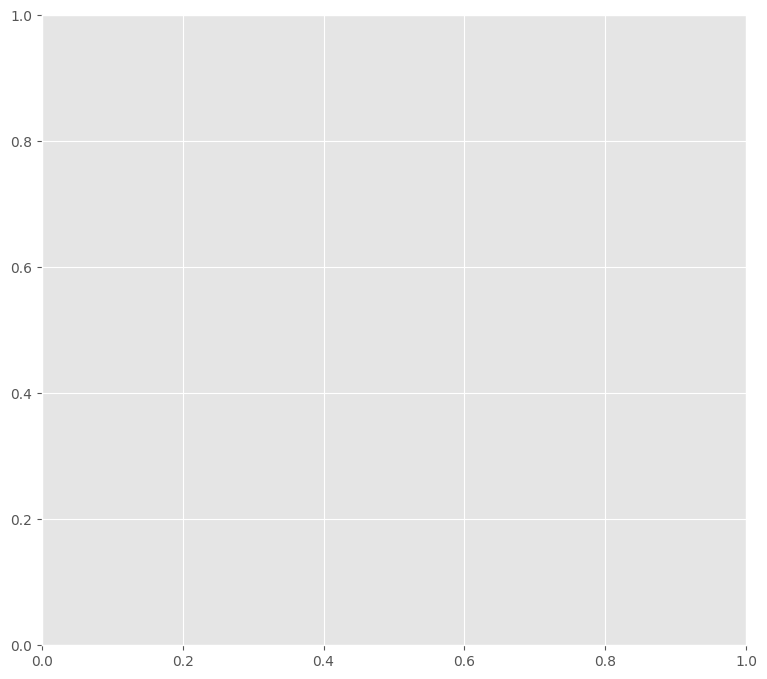

In [49]:
fig, ax = plt.subplots(figsize = (20, 18))
plt.subplot(2, 2, 1)
text_cat1 = ' '.join(all_data.loc[(all_data['FurLength'] == 1) & (all_data['Type'] == 'Cat'), 'Breed1_name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text_cat1)
plt.imshow(wordcloud)
plt.title('Top cat breed1 with short fur')
plt.axis("off")

plt.subplot(2, 2, 2)
text_dog1 = ' '.join(all_data.loc[(all_data['FurLength'] == 1) & (all_data['Type'] == 'Dog'), 'Breed1_name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text_dog1)
plt.imshow(wordcloud)
plt.title('Top dog breed1 with short fur')
plt.axis("off")

plt.subplot(2, 2, 3)
text_cat2 = ' '.join(all_data.loc[(all_data['FurLength'] == 2) & (all_data['Type'] == 'Cat'), 'Breed1_name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text_cat2)
plt.imshow(wordcloud)
plt.title('Top cat breed1 with medium fur')
plt.axis("off")

plt.subplot(2, 2, 4)
text_dog2 = ' '.join(all_data.loc[(all_data['FurLength'] == 2) & (all_data['Type'] == 'Dog'), 'Breed1_name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text_dog2)
plt.imshow(wordcloud)
plt.title('Top dog breed2 with medium fur')
plt.axis("off")
plt.show()

In [ ]:
c = 0
strange_pets = []
for i, row in all_data[all_data['Breed1_name'].str.contains('air')].iterrows():
    if 'Short' in row['Breed1_name'] and row['FurLength'] == 1:
        pass
    elif 'Medium' in row['Breed1_name'] and row['FurLength'] == 2:
        pass
    elif 'Long' in row['Breed1_name'] and row['FurLength'] == 3:
        pass
    else:
        c += 1
        strange_pets.append((row['PetID'], row['Breed1_name'], row['FurLength']))
        
print(f"There are {c} pets whose breed and fur length don't match")

It seems that almost one thousand pets have mismatch in breeds and fur lengths. Let's see!

In [ ]:
strange_pets = [p for p in strange_pets if p[0] in images]
fig = plt.figure(figsize=(25, 12))
fur_dict = {1: 'Short', 2: 'Medium', 3: 'long'}
for i, s in enumerate(random.sample(strange_pets, 12)):
    ax = fig.add_subplot(3, 4, i+1, xticks=[], yticks=[])

    im = Image.open("../input/train_images/" + s[0] + '-1.jpg')
    plt.imshow(im)
    ax.set_title(f'Breed: {s[1]} \n Fur length: {fur_dict[s[2]]}')
plt.show();

Everybody lies!

Sometimes breed is more correct, sometimes fur length... I suppose we could create a feature showing whether breed and fur length match.

### Health

There are four features showing health of the pets:

* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)

I think that these features are very important - most people would prefer a healthy pet. While sterilization isn't the main concern, having healty and dewormed pet should have a great importance. Let's see whether I'm right!

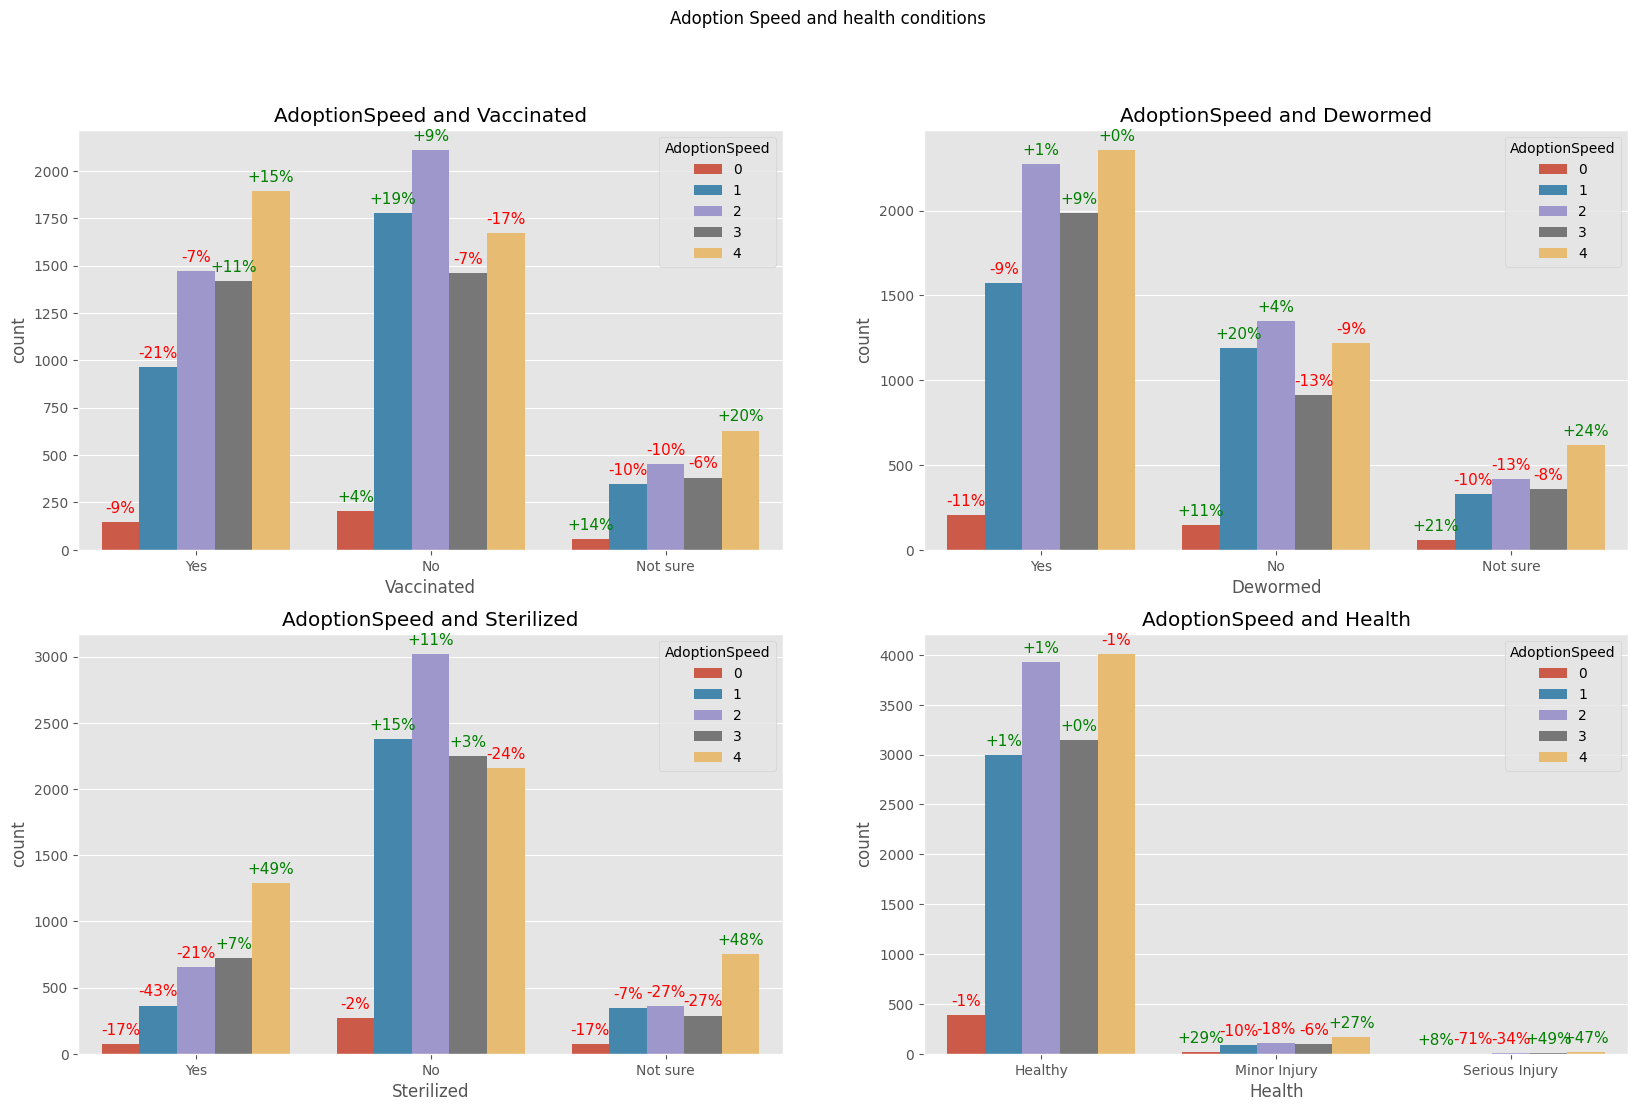

In [50]:
plt.figure(figsize=(20, 12));
plt.subplot(2, 2, 1)
make_count_plot(df=train, x='Vaccinated', title='Vaccinated')
plt.xticks([0, 1, 2], ['Yes', 'No', 'Not sure']);
plt.title('AdoptionSpeed and Vaccinated');

plt.subplot(2, 2, 2)
make_count_plot(df=train, x='Dewormed', title='Dewormed')
plt.xticks([0, 1, 2], ['Yes', 'No', 'Not sure']);
plt.title('AdoptionSpeed and Dewormed');

plt.subplot(2, 2, 3)
make_count_plot(df=train, x='Sterilized', title='Sterilized')
plt.xticks([0, 1, 2], ['Yes', 'No', 'Not sure']);
plt.title('AdoptionSpeed and Sterilized');

plt.subplot(2, 2, 4)
make_count_plot(df=train, x='Health', title='Health')
plt.xticks([0, 1, 2], ['Healthy', 'Minor Injury', 'Serious Injury']);
plt.title('AdoptionSpeed and Health');

plt.suptitle('Adoption Speed and health conditions');

* Almost all pets are healthy! Pets with minor injuries are rare and sadly they aren't adopted well. Number of pets with serious injuries is negligible.
* It is interesting that people prefer non-vaccinated pets. Maybe they want to bring pets to vets themselves...
* People also prefer non-sterilized pets! Maybe they want puppies/kittens :)
* Quite important is the fact that when there is no information about health condition, the probability of not being adopted is much higher;

Let's have a look at most popular health conditions.

In [51]:
train['health'] = train['Vaccinated'].astype(str) + '_' + train['Dewormed'].astype(str) + '_' + train['Sterilized'].astype(str) + '_' + train['Health'].astype(str)
test['health'] = test['Vaccinated'].astype(str) + '_' + test['Dewormed'].astype(str) + '_' + test['Sterilized'].astype(str) + '_' + test['Health'].astype(str)


make_factor_plot(df=train.loc[train['health'].isin(list(train.health.value_counts().index[:5]))], x='health', col='AdoptionSpeed', title='Counts of pets by main health conditions and Adoption Speed')

AttributeError: module 'seaborn' has no attribute 'factorplot'

* Healthy, dewormed and non-sterilized pets tend to be adopted faster!
* Completely healthy pets are... more likely to be not adopted! I suppose that means that a lot of people pay attention to other characteristics;
* And healthy pets with no information (not sure value) also tend to be adopted less frequently. Maybe people prefer having information, even if it is negative;

In [ ]:
plt.figure(figsize=(20, 16))
plt.subplot(3, 2, 1)
sns.violinplot(x="AdoptionSpeed", y="Age", data=train);
plt.title('Age distribution by Age');
plt.subplot(3, 2, 3)
sns.violinplot(x="AdoptionSpeed", y="Age", hue="Vaccinated", data=train);
plt.title('Age distribution by Age and Vaccinated');
plt.subplot(3, 2, 4)
sns.violinplot(x="AdoptionSpeed", y="Age", hue="Dewormed", data=train);
plt.title('Age distribution by Age and Dewormed');
plt.subplot(3, 2, 5)
sns.violinplot(x="AdoptionSpeed", y="Age", hue="Sterilized", data=train);
plt.title('Age distribution by Age and Sterilized');
plt.subplot(3, 2, 6)
sns.violinplot(x="AdoptionSpeed", y="Age", hue="Health", data=train);
plt.title('Age distribution by Age and Health');

### Quantity
Sometimes there are several pets in one advertisement.

In [52]:
train.loc[train['Quantity'] > 11][['Name', 'Description', 'Quantity', 'AdoptionSpeed']].head(10)

,Name,Description,Quantity,AdoptionSpeed
263,20 Little Puppies,"These are 20 puppies, from 2 stray mums need good homes. They are 2 weeks old. If you can give them a good home without caging or chaining, please whatsapp or msg Ms Grace Bong tel no:",20,4
320,18 Cats For NEED HOMES!!,"YOU can CONTACT the couple at if you are interested. MORE pictures available here: THE HISTORY: They were basically abandoned by their previous owner who left them behind when he moved out. The couple that moved in was left to look after them and has slowly been finding homes for the cats over the last year. There were 28 to begin with and there are 18 left. The last 18 NEED HOMES URGENTLY as the couple is no longer able to care for them. Due to some personal issues, and a new baby then need...",18,4
396,"Giant, Cookie & Snoopy. ! Thanks!","puppies for adoption. Rescued by some good samaritans. No information on breeds, probably mongrels. All about a month old. They have been dewormed but not yet vaccinated. Cookie- female- Smaller than the rest but fiesty! Snoopy- male- Attention seeker. LOVES wagging his tail! Giant- male- Gentle giant. Very soft fur coat! Very playful! Some videos: Giant and his tennis ball- Giant playing with Snoopy- Giant being bullied- ----------------------------------------------------------------------...",12,2
427,OMIEY'S HOME,"Hi, kepada sesiapa yang berminat untuk adopt kucing-kucing sila hubungi saya . Di sini ada berbagai jenis kucing, dari short hair - long hair.",20,4
823,Pancho & Tita,"Pancho and Tita are 2 adorable, playful kittens. They can be shy at first but once they get to know you they are the sweetest pets anyone could ask for. Available for adoption now. They are very, very close so we are looking for someone who can take them both.",12,2
1302,NaN,"Sebare Bengal is a specialist catery breeding quality bengal cats. View our web Due to our passion with cats, we have rescued and feed the stray cats until its become healty and ready to go to a new family. Currently, we have 14 DSH ready for adoption from age 3 months to year. 3 male and 11 female. Adoption fee is free but if you kind enough, we will be appreciate if you can donate IAMS Chicken foods for us to feed the cats.",14,4
1305,Bailey,Bailey is an obedient and loyal dog Her owner is terminaaly ill and is unable to care for her,20,4
1404,NaN,"I had uploaded the pups' group photos earlier. But my kind hearted friend Nancy, took 17 of them home today and took individual shots of them and labelled their sex accordingly. Aren't they adorable. We heard the sad news from the school guard this morning that the headmistress will be calling MPPJ soon to 'get rid of all of them'. The pups are now sheltering with their mummies in a school compound in Bandar Utama. Pleeeease help to adopt them SOON. Do contact Nancy at if you want to take ho...",17,2
1659,Cats From TTDI Now In Omiey's Home,"Hi feline lovers, There are 40 cats desperately seeking new homes before they are taken away from DBKL! This video link shows the lady who has been keeping these cats: Her neighbors seem to dislike cats, so they complained to DBKL. DBKL came to her house and told her to get rid of those cats. They'll be coming back to her house this Monday (6th February ) and she can only have 1 cat. DBKL will take the other cats and put them to sleep. She's looking for people who wants to adopt her cats and...",20,2
2558,( 0 Puppies Left )14+2 Puppies,"They are 2 stray mother dogs gave birth 14 puppies at car park lot hidden place. So, I bring all puppies back to my condo temporary take care and for adopters. Please help and give them 2nd chance. Only serious adopters welcome. Someone who will give the pups a loving home. Please call , SMS or Email , if you are interested to adopt. Thank you.",16,2


In [53]:
train['Quantity'].value_counts().head(10)

1     11565
2      1422
3       726
4       531
5       333
6       185
7        84
8        52
9        33
10       19
Name: Quantity, dtype: int64

Sometimes there is a huge amount of pets in some advertisements! But at the same time sometimes text and the quantity don't match. For example:

    Pancho and Tita are 2 adorable, playful kittens. They can be shy at first but once they get to know you they are the sweetest pets anyone could ask for. Available for adoption now. They are very, very close so we are looking for someone who can take them both.
    
 Obvously there are only two kittens, but the quantity is 12 for some reason.
 
 One thing worth noticing that sometimes all these pet are adopted which is great!
 
 For the sake of plotting I'll create a new variable, where 6 pets in one advertizement will the the max amount.

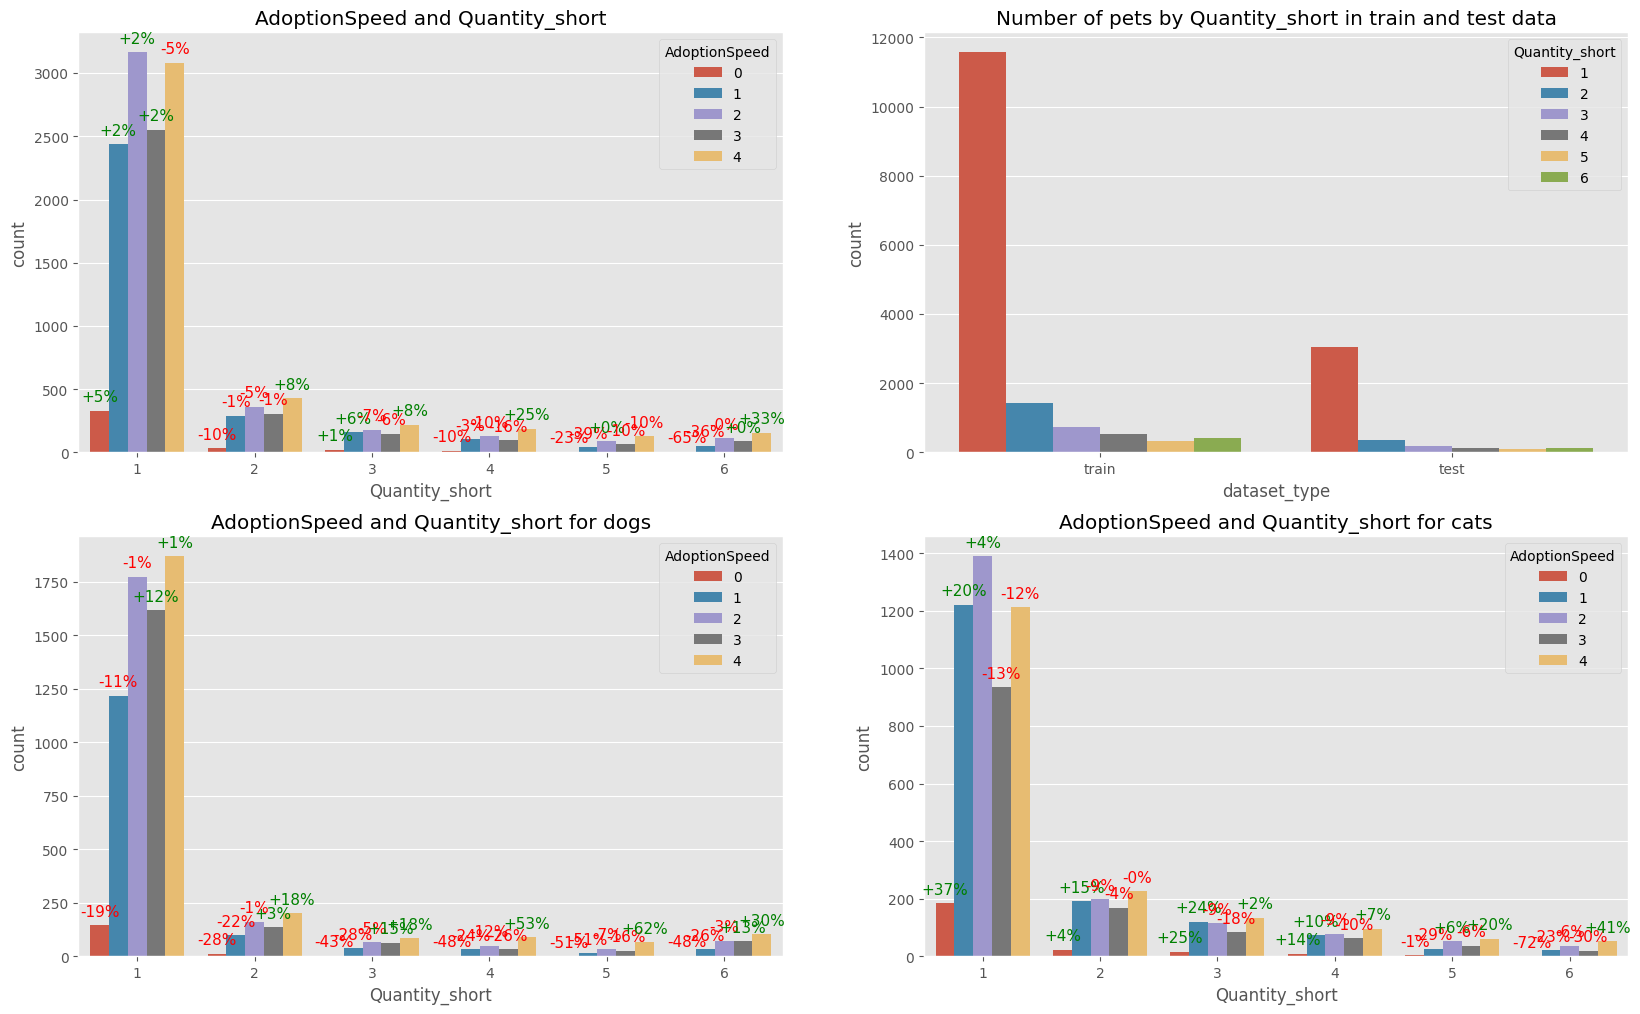

In [54]:
train['Quantity_short'] = train['Quantity'].apply(lambda x: x if x <= 5 else 6)
test['Quantity_short'] = test['Quantity'].apply(lambda x: x if x <= 5 else 6)
all_data['Quantity_short'] = all_data['Quantity'].apply(lambda x: x if x <= 5 else 6)
plot_four_graphs(col='Quantity_short', main_title='Quantity_short', dataset_title='Number of pets by Quantity_short in train and test data')

It seems that quantity has little to do with adoption speed. This is good, it means that abandoned cats/dogs with kittens/puppies have chances of being adopted! Though it seems that single cats have somewhat higher chances that single dogs.

### Fee
One of interesting features is adoption fee. Some pets can be gotten for free, adopting some required paying a certain amount.

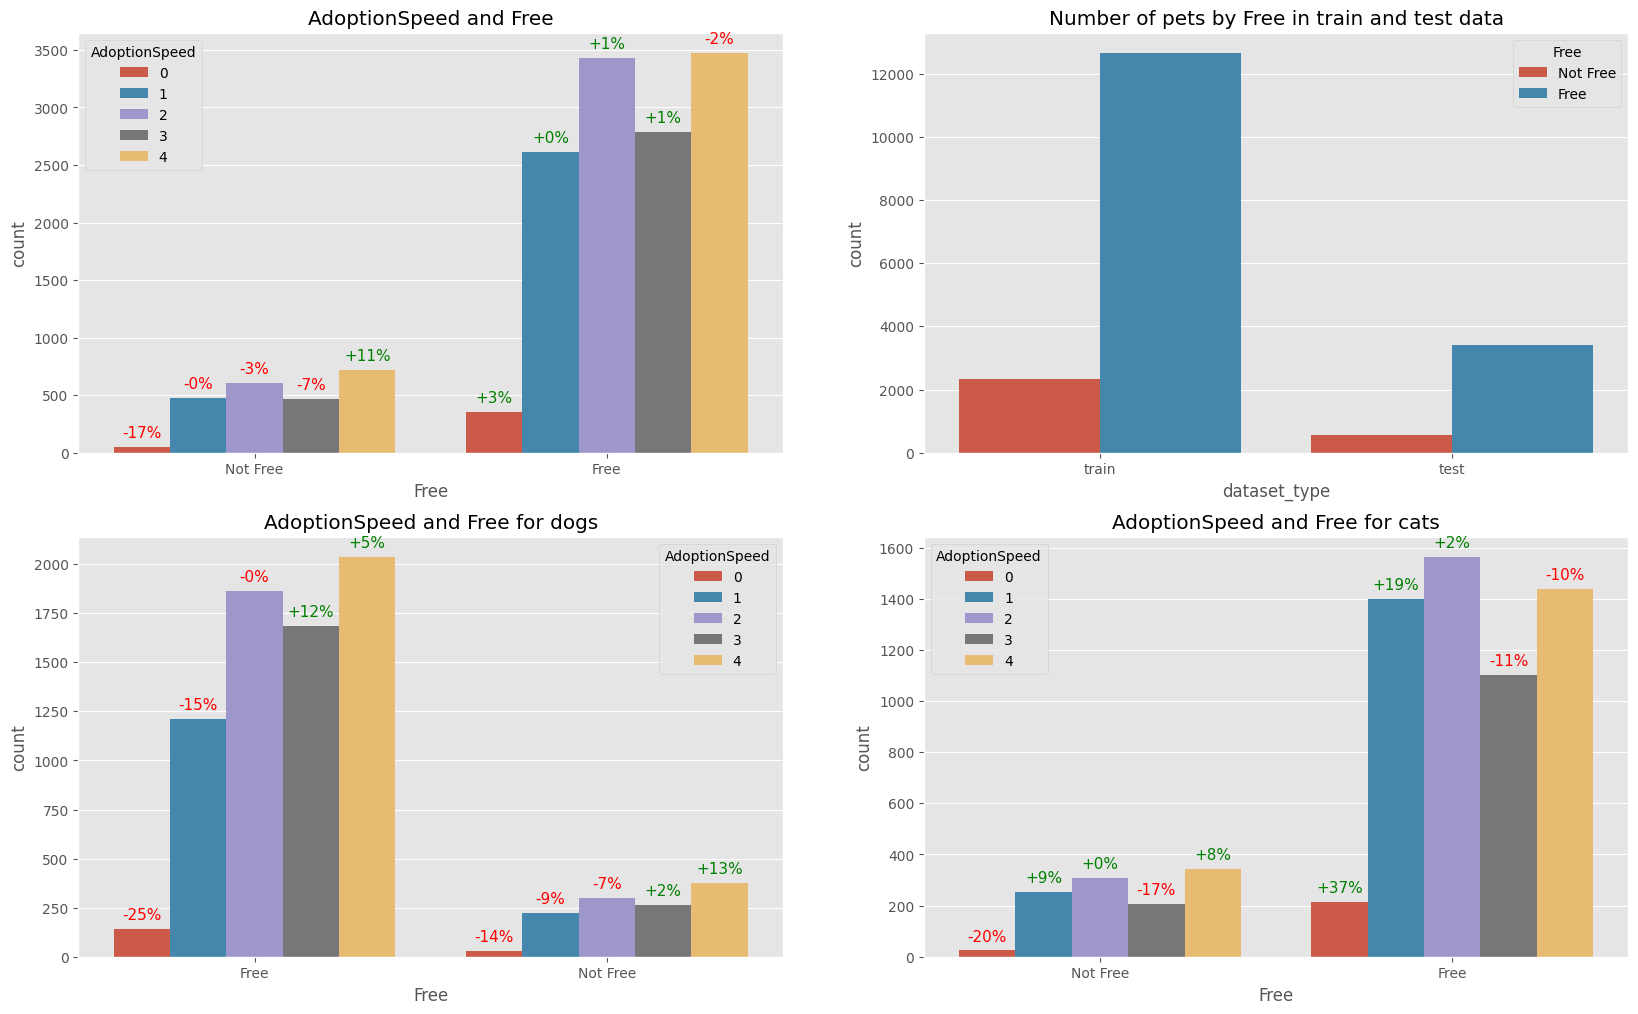

In [55]:
train['Free'] = train['Fee'].apply(lambda x: 'Free' if x == 0 else 'Not Free')
test['Free'] = test['Fee'].apply(lambda x: 'Free' if x == 0 else 'Not Free')
all_data['Free'] = all_data['Fee'].apply(lambda x: 'Free' if x == 0 else 'Not Free')
plot_four_graphs(col='Free', main_title='Free', dataset_title='Number of pets by Free in train and test data')

Most pets are free and it seems that asking for a fee slightly desreased the chance of adoption. Also free cats are adopted faster than free dogs

In [56]:
all_data.sort_values('Fee', ascending=False)[['Name', 'Description', 'Fee', 'AdoptionSpeed', 'dataset_type']].head(10)

,Name,Description,Fee,AdoptionSpeed,dataset_type
8722,Khaleesi And Drogo,"Both pups are family home trained. They love their walks on lead and off lead. Both male and female are from different lineage and both have MKA Reg Certs. They are 4mths and at perfect age for training. The 2pups know some commands like ""sit"" ""outside"" ""leave"" ""crate"" and more. They are family friendly and can stay/sleep indoors and out. They've just learnt to swim and belly rubs. Great dogs for families that wants a pet and a watchdog too. All vaccines complete, dewormed, microchipped and ...",3000,3.0,train
10477,Bull Dog,"Found this bull dog near my neighbourhood for a month now. I have 3 dogs myself at home. Cannot take care of it. Hopefully if there is someone who is loving who can take care of it. It is very cute and friendly but the saliva keep on drooling. overall there is nothing. forgot to mention, please keep him indoor. He likes to sleep on mattress or sofa, if can please prepare a mattress for him. PLEASE SMS , DONT CALL",2000,1.0,train
207,NaN,These two german shepherds are looking for a home together as their owner has passed away. One is 4 yrs old the second is 2.5-3 yrs old. The 4 yr old has a deformed back leg and recently had her tail amputated but she is able to continue walking. Good temperament. Dogs will be spayed before passing to adopter. Adoption fee will be used to cover spaying costs.,1500,NaN,test
2078,Rottweiler - Adoption,Open for Adoption with Fees Looking for new lovely home due to owner lack of time & care... Vaccination & Deworm up to date Contact me for more details,1000,2.0,train
3469,Cheras,We have just rescued a dog at 18.5km grand saga highway from Cheras heading to Kajang. We believe it is a stray and he is now undergoing a surgery at everise veterinarian clinic at Kajang Prima. According to the doctor his vertebrate t-12 and t-13 has broken and suffered from a fracture of his left tibia and fibula. The brave dog will recuperate for around one week before he can be adopted. We are currently urgently looking for people who has compassion towards injured (and may even be paral...,1000,NaN,test
4844,Coda,She is pure breed Siberian husky. Born at July . She has beautiful blue eye. Character is very gentle. Never bark or be aggressive. Her owner had to move from previous house and new place not allows dog. So we foster her for few month. I love her so much. But she requires more exercise than I can give. (Currently I walk her 1hour/day) and our house has no garden but only balcony. I feel that we better find suitable home ( experienced dog lover with enough time and space) and current owner al...,1000,2.0,train
8834,Adpoted,adpoted,1000,0.0,train
8879,Rottweiler Semi-Adult - Adoption,Looking for new lovely home due to owner lack of time & care... Vaccination & Deworm up to date Contact me for more details,1000,1.0,train
9782,NaN,Available open for booking cute kitten Solid white Current just a month Ready taken end march Thank you,800,2.0,train
9745,Oscar,"Oscar was found in Ara Damansara recently. My friend was walking his two dogs when this friendly chap decided to follow him home. We can't track his owner and wants to find him a good home. He has put on weight and doing well. Currently boarding at a vet. Active and playful chap, but very gentle for his size. Very affectionate and smart. Walks at yr pace without pulling the leash, knows how to sit, come up etc. The fee is not a profit _ it is to cover his boarding cost and other bills.",800,2.0,train


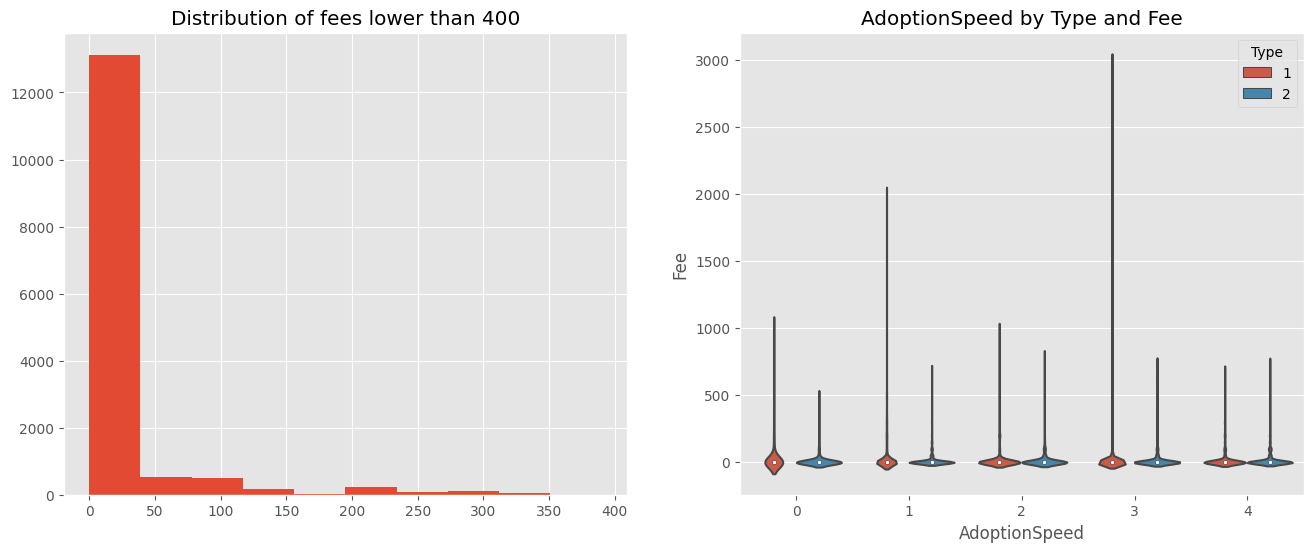

In [57]:
plt.figure(figsize=(16, 6));
plt.subplot(1, 2, 1)
plt.hist(train.loc[train['Fee'] < 400, 'Fee']);
plt.title('Distribution of fees lower than 400');

plt.subplot(1, 2, 2)
sns.violinplot(x="AdoptionSpeed", y="Fee", hue="Type", data=train);
plt.title('AdoptionSpeed by Type and Fee');

* It is interesting that pets with high fee tend to be adopted quite fast! Maybe people prefer to pay for "better" pets: healthy, trained and so on;
* Most pets are given for free and fees are usually lower than 100 $;
* Fees for dogs tend to be higher, though these are rare cases anyway.

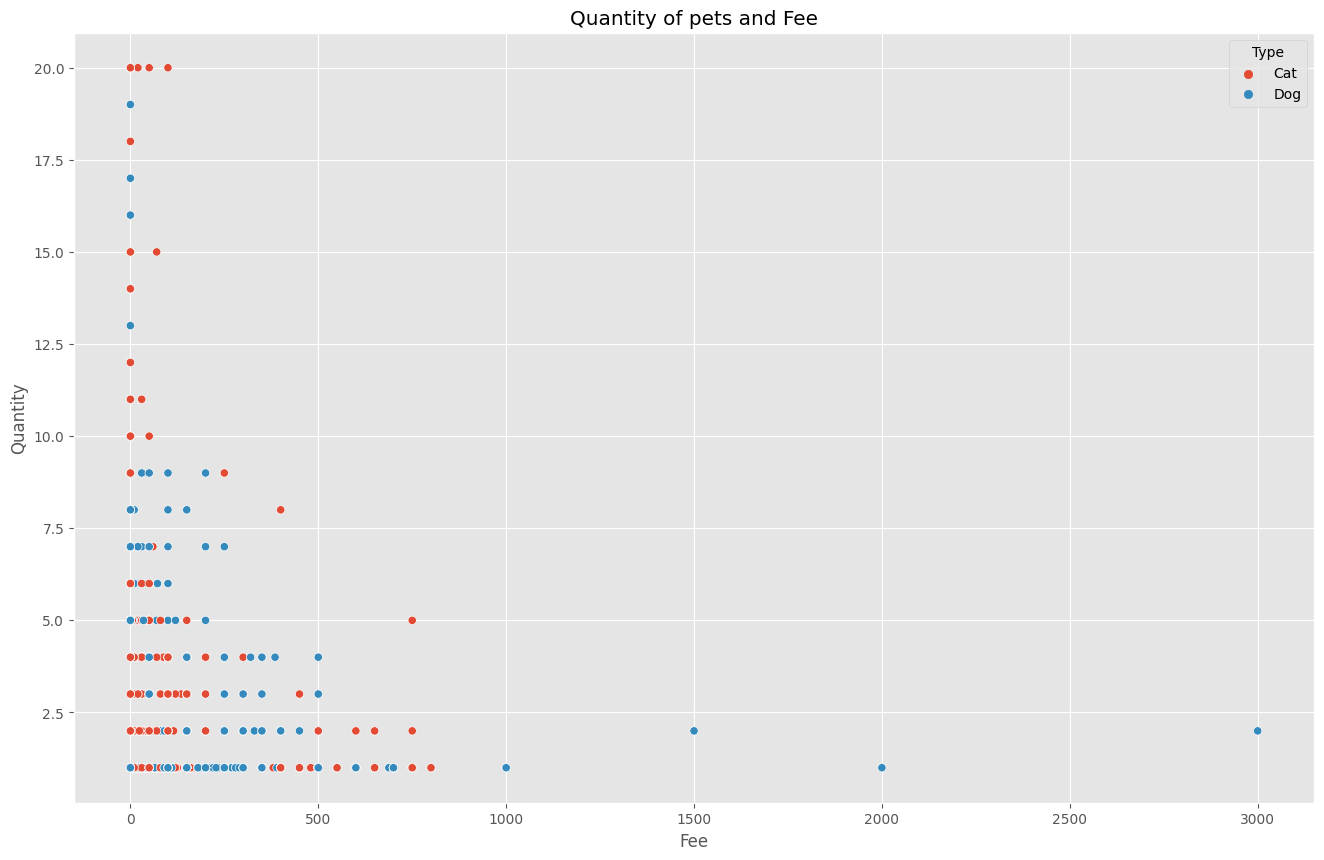

In [58]:
plt.figure(figsize=(16, 10));
sns.scatterplot(x="Fee", y="Quantity", hue="Type",data=all_data);
plt.title('Quantity of pets and Fee');

It seems that fees and pet quantity have inversely proportional relationship. The less pets, the higher is the fee. I suppose these single pets are better trained and prepared than most others.

### State

In [59]:
states_dict = {k: v for k, v in zip(states['StateID'], states['StateName'])}
train['State_name'] = train['State'].apply(lambda x: '_'.join(states_dict[x].split()) if x in states_dict else 'Unknown')
test['State_name'] = test['State'].apply(lambda x: '_'.join(states_dict[x].split()) if x in states_dict else 'Unknown')
all_data['State_name'] = all_data['State'].apply(lambda x: '_'.join(states_dict[x].split()) if x in states_dict else 'Unknown')

In [60]:
all_data['State_name'].value_counts(normalize=True).head()

Selangor        0.556130
Kuala_Lumpur    0.259267
Pulau_Pinang    0.071342
Johor           0.033430
Perak           0.029897
Name: State_name, dtype: float64

Sadly I don't know anything about Malaysia’s states, so I can only say that top three states account for ~90% of ads. Let's have a look at them.

In [61]:
make_factor_plot(df=train.loc[train['State_name'].isin(list(train.State_name.value_counts().index[:3]))], x='State_name', col='AdoptionSpeed', title='Counts of pets by states and Adoption Speed')

AttributeError: module 'seaborn' has no attribute 'factorplot'

Intetestingly top-2 and top-3 states have lower rates of adoption.

### Rescuer
We have unique hashes for resquers.

In [ ]:
all_data['RescuerID'].value_counts().head()

Top-5 resquers managed a lot of pets!
I wonder whether these are individual people or organizations. Let's have a look at them.

In [ ]:
make_factor_plot(df=train.loc[train['RescuerID'].isin(list(train.RescuerID.value_counts().index[:5]))], x='RescuerID', col='AdoptionSpeed', title='Counts of pets by rescuers and Adoption Speed', col_wrap=5)

Wow! The resquer with the highest amount of resqued pets has the best adoption rate! On the other hand the third one has the worst rate :(

### VideoAmt

In [62]:
train['VideoAmt'].value_counts()

0    14419
1      417
2       92
3       36
4       15
5        7
6        4
8        2
7        1
Name: VideoAmt, dtype: int64

Hm. In most cases there are no videos at all. Sometimes there is one video, more than one video is quite rare. We don't have videos and considering a huge disbalance in values I'm not sure this variable will be useful.

### PhotoAmt

In [63]:
print(F'Maximum amount of photos in {train["PhotoAmt"].max()}')
train['PhotoAmt'].value_counts().head()

Maximum amount of photos in 30.0


1.0    3075
2.0    2518
3.0    2511
5.0    2147
4.0    1881
Name: PhotoAmt, dtype: int64

In [64]:
make_factor_plot(df=train.loc[train['PhotoAmt'].isin(list(train.PhotoAmt.value_counts().index[:5]))], x='PhotoAmt', col='AdoptionSpeed', title='Counts of pets by PhotoAmt and Adoption Speed', col_wrap=5)

AttributeError: module 'seaborn' has no attribute 'factorplot'

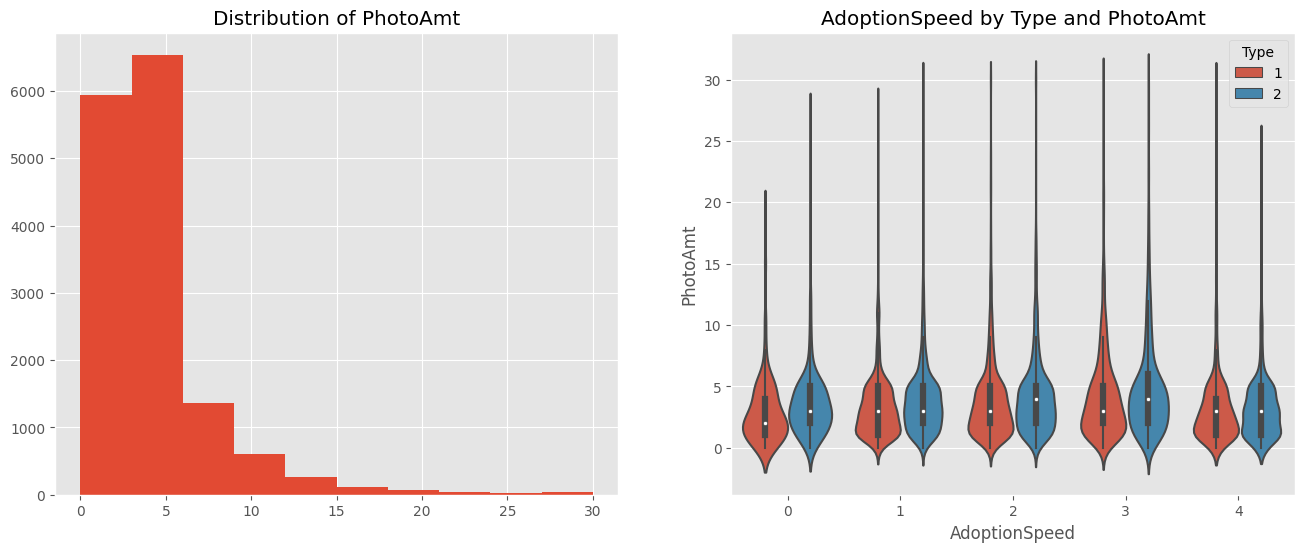

In [65]:
plt.figure(figsize=(16, 6));
plt.subplot(1, 2, 1)
plt.hist(train['PhotoAmt']);
plt.title('Distribution of PhotoAmt');

plt.subplot(1, 2, 2)
sns.violinplot(x="AdoptionSpeed", y="PhotoAmt", hue="Type", data=train);
plt.title('AdoptionSpeed by Type and PhotoAmt');

Pets can have up to 30 photos! That's a lot! But I'm not convinced that amount of photoes has any real influence.

### Description

Description contains a lot of important information, let' analyze it!

NameError: name 'WordCloud' is not defined

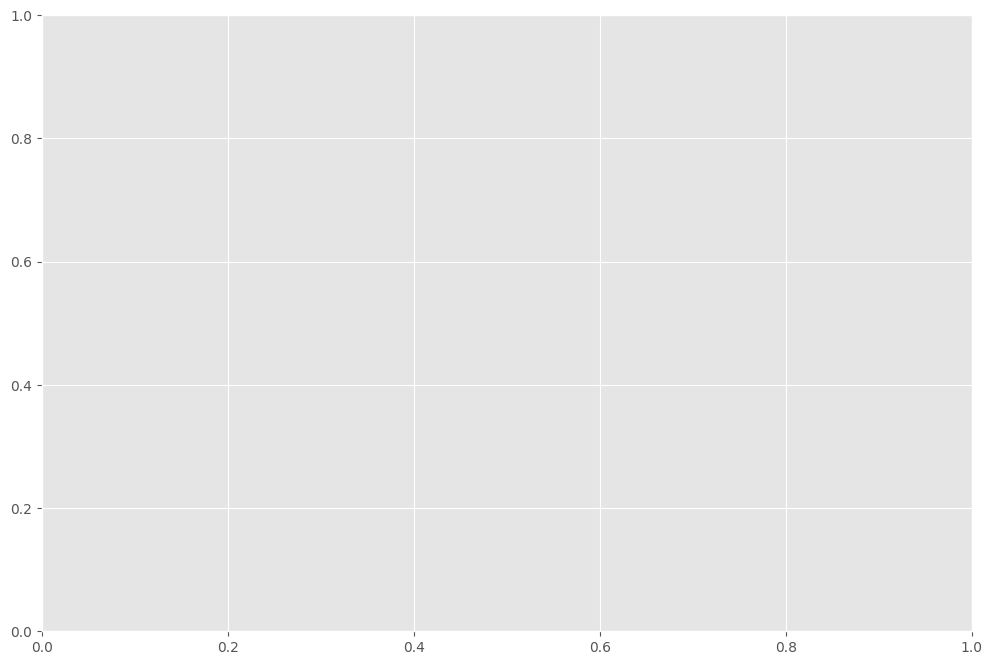

In [66]:
fig, ax = plt.subplots(figsize = (12, 8))
text_cat = ' '.join(all_data['Description'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_cat)
plt.imshow(wordcloud)
plt.title('Top words in description');
plt.axis("off");

There are too many similar general words like "cat". We need to go deeper.

Let's use ELI5 library for prediction explanation. I'll fit a basic vectorizer on desctriptions and build a simple Random Forest model. Then we will look at words which caused certain labels to be predicted.

In [67]:
tokenizer = TweetTokenizer()
vectorizer = TfidfVectorizer(ngram_range=(1, 2), tokenizer=tokenizer.tokenize)

vectorizer.fit(all_data['Description'].fillna('').values)
X_train = vectorizer.transform(train['Description'].fillna(''))

rf = RandomForestClassifier(n_estimators=20)
rf.fit(X_train, train['AdoptionSpeed'])

NameError: name 'TweetTokenizer' is not defined

In [68]:
for i in range(5):
    print(f'Example of Adoption speed {i}')
    text = train.loc[train['AdoptionSpeed'] == i, 'Description'].values[0]
    print(text)
    display(eli5.show_prediction(rf, doc=text, vec=vectorizer, top=10))

Example of Adoption speed 0
I just found it alone yesterday near my apartment. It was shaking so I had to bring it home to provide temporary care.


NameError: name 'eli5' is not defined

Some words/phrases seem to be useful, but it seems that different adoption speed classes could have similar important words...

In [69]:
train['Description'] = train['Description'].fillna('')
test['Description'] = test['Description'].fillna('')
all_data['Description'] = all_data['Description'].fillna('')

train['desc_length'] = train['Description'].apply(lambda x: len(x))
train['desc_words'] = train['Description'].apply(lambda x: len(x.split()))

test['desc_length'] = test['Description'].apply(lambda x: len(x))
test['desc_words'] = test['Description'].apply(lambda x: len(x.split()))

all_data['desc_length'] = all_data['Description'].apply(lambda x: len(x))
all_data['desc_words'] = all_data['Description'].apply(lambda x: len(x.split()))

train['averate_word_length'] = train['desc_length'] / train['desc_words']
test['averate_word_length'] = test['desc_length'] / test['desc_words']
all_data['averate_word_length'] = all_data['desc_length'] / all_data['desc_words']

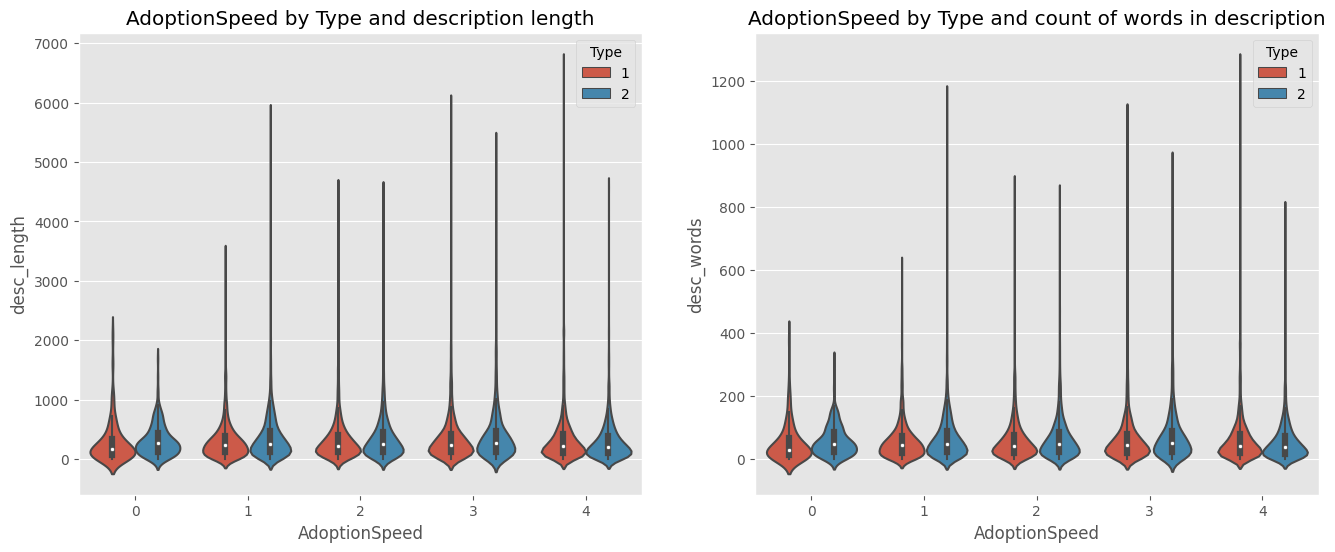

In [70]:
plt.figure(figsize=(16, 6));
plt.subplot(1, 2, 1)
sns.violinplot(x="AdoptionSpeed", y="desc_length", hue="Type", data=train);
plt.title('AdoptionSpeed by Type and description length');

plt.subplot(1, 2, 2)
sns.violinplot(x="AdoptionSpeed", y="desc_words", hue="Type", data=train);
plt.title('AdoptionSpeed by Type and count of words in description');

Interestingly pets with short text in ads are adopted quickly. Or maybe longer descriptions mean more problems in the pets, therefore adoption speed is lower?

### Sentiment
We have run each pet profile's description through Google's Natural Language API, providing analysis on sentiment and key entities. You may optionally utilize this supplementary information for your pet description analysis. There are some descriptions that the API could not analyze. As such, there are fewer sentiment files than there are rows in the dataset. 

In [71]:
sentiment_dict = {}
for filename in os.listdir('../input/train_sentiment/'):
    with open('../input/train_sentiment/' + filename, 'r') as f:
        sentiment = json.load(f)
    pet_id = filename.split('.')[0]
    sentiment_dict[pet_id] = {}
    sentiment_dict[pet_id]['magnitude'] = sentiment['documentSentiment']['magnitude']
    sentiment_dict[pet_id]['score'] = sentiment['documentSentiment']['score']
    sentiment_dict[pet_id]['language'] = sentiment['language']

for filename in os.listdir('../input/test_sentiment/'):
    with open('../input/test_sentiment/' + filename, 'r') as f:
        sentiment = json.load(f)
    pet_id = filename.split('.')[0]
    sentiment_dict[pet_id] = {}
    sentiment_dict[pet_id]['magnitude'] = sentiment['documentSentiment']['magnitude']
    sentiment_dict[pet_id]['score'] = sentiment['documentSentiment']['score']
    sentiment_dict[pet_id]['language'] = sentiment['language']

FileNotFoundError: [Errno 2] No such file or directory: '../input/train_sentiment/'

In [72]:
train['lang'] = train['PetID'].apply(lambda x: sentiment_dict[x]['language'] if x in sentiment_dict else 'no')
train['magnitude'] = train['PetID'].apply(lambda x: sentiment_dict[x]['magnitude'] if x in sentiment_dict else 0)
train['score'] = train['PetID'].apply(lambda x: sentiment_dict[x]['score'] if x in sentiment_dict else 0)

test['lang'] = test['PetID'].apply(lambda x: sentiment_dict[x]['language'] if x in sentiment_dict else 'no')
test['magnitude'] = test['PetID'].apply(lambda x: sentiment_dict[x]['magnitude'] if x in sentiment_dict else 0)
test['score'] = test['PetID'].apply(lambda x: sentiment_dict[x]['score'] if x in sentiment_dict else 0)

all_data['lang'] = all_data['PetID'].apply(lambda x: sentiment_dict[x]['language'] if x in sentiment_dict else 'no')
all_data['magnitude'] = all_data['PetID'].apply(lambda x: sentiment_dict[x]['magnitude'] if x in sentiment_dict else 0)
all_data['score'] = all_data['PetID'].apply(lambda x: sentiment_dict[x]['score'] if x in sentiment_dict else 0)

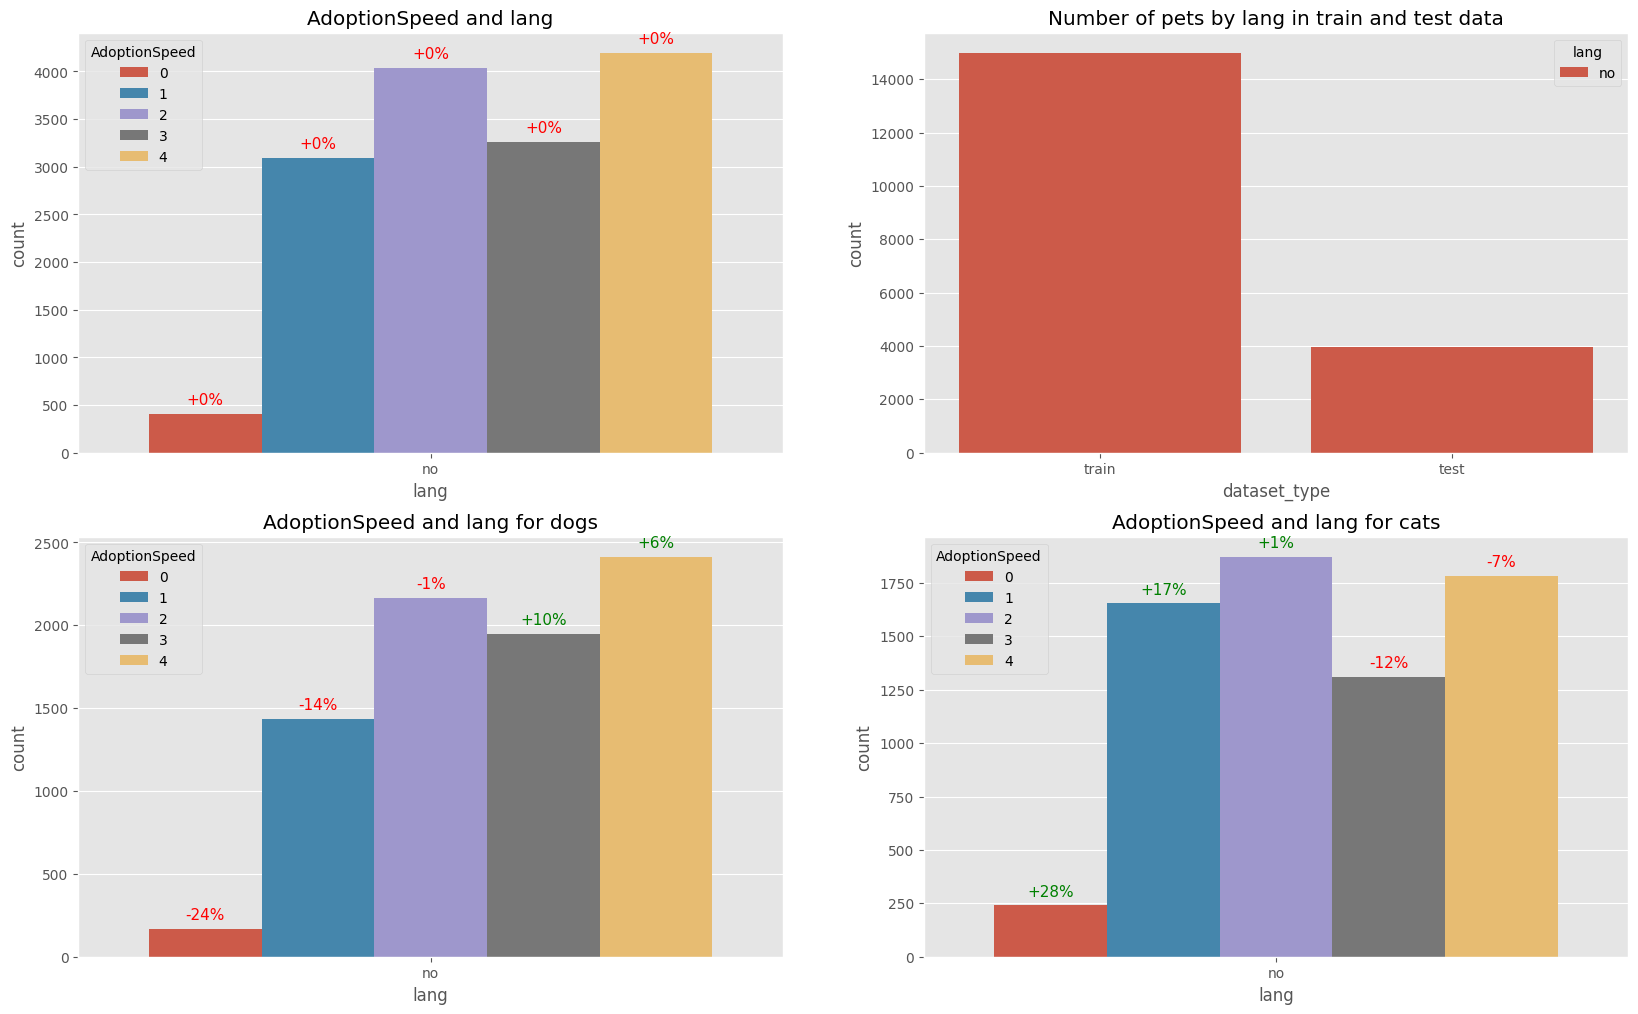

In [73]:
plot_four_graphs(col='lang', main_title='lang', dataset_title='Number of pets by lang in train and test data')

Well, English is the most common language by far, so language feature will hardly help.

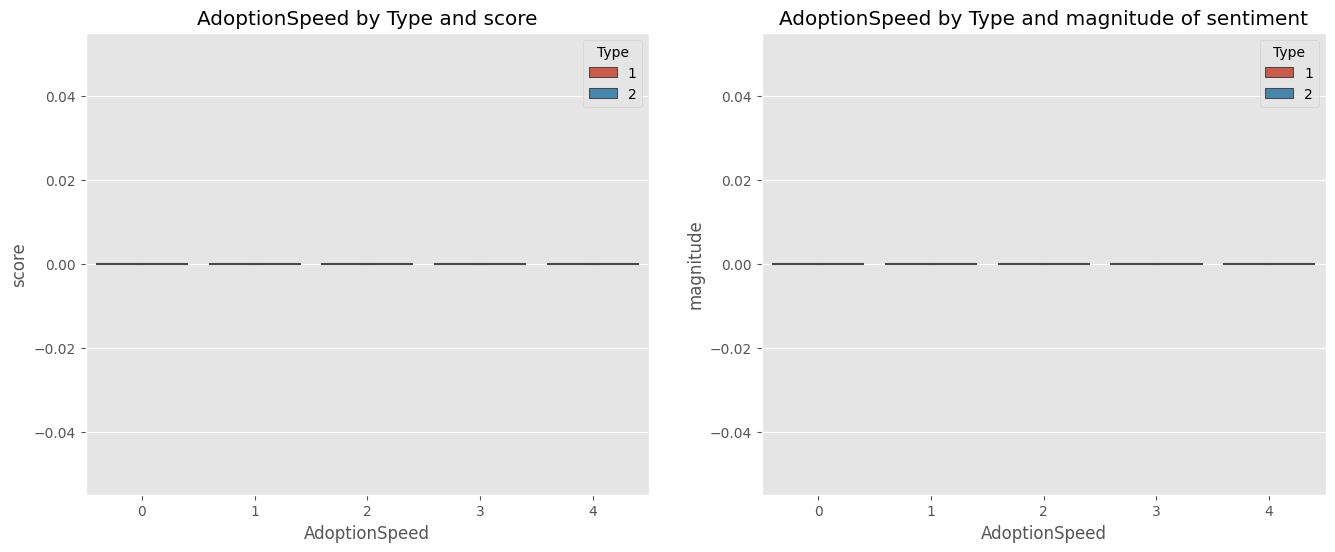

In [74]:
plt.figure(figsize=(16, 6));
plt.subplot(1, 2, 1)
sns.violinplot(x="AdoptionSpeed", y="score", hue="Type", data=train);
plt.title('AdoptionSpeed by Type and score');

plt.subplot(1, 2, 2)
sns.violinplot(x="AdoptionSpeed", y="magnitude", hue="Type", data=train);
plt.title('AdoptionSpeed by Type and magnitude of sentiment');

It seems that the lower is the magnitude of score, the faster pets are adopted.